<a href="https://colab.research.google.com/github/hachteja/BlankPlugin/blob/master/DL_EELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**JAH, September 14th, 2020:** Here, is the cleaned up notebook used to generate some of the figures. Everything should run without modification.

# Low loss EELS of plasmonic semiconducting nanoparticles
## Identifying regions with distinct physical mechanisms
9.16.20

Notebook created by Kevin Roccapriore with Jordan Hachtel, Maxim Ziatdinov, and Sergei V. Kalinin 

This is a collection of analysis tools designed to interpret and help understand the information acquired from EELS studies, particularly those in the low loss spectrum.

These tools are applicable to study plasmons in the visible down to mid-IR frequencies 

The following data was collected by Kevin Roccapriore and Jordan Hachtel using the monochromated abberation corrected scanning transmission electron microscope (MACSTEM)

In [ ]:
#@title Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import tensorflow as tf
import json

from matplotlib.patches import Rectangle,Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import cm
from scipy import interpolate
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import NMF
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, Activation, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Reshape, UpSampling1D, BatchNormalization 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [ ]:
#@title Define Functions

def LoadEELS_SI(fname):
    """
    Loads an EEL Spectrum Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: dat   - data (numpy array)
            cal   - pixel calibration in nm (float)
            disp  - energy dispersion in eV (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    disp=mdat['spatial_calibrations'][-1]['scale']
    return dat,cal,disp

def LoadImage(fname):
    """
    Loads a 2D STEM Image
    
    Input:  fname - path to either .npy or .json file that (string)
    Output: im    - image data (numpy array)
            cal   - pixel calibration in nm (float)
            mdat  - metadata (python dictionary)
    """    

    if fname.endswith('npy'): fname=fname[:-4]
    if fname.endswith('json'): fname=fname[:-5]
    dat=np.load(fname+'.npy')
    mdat= json.load(open(fname+'.json','r'))
    cal=mdat['spatial_calibrations'][0]['scale']
    return dat,cal

def Display_SI(dat,cal=1.,scale=None,cmap=cm.Greys_r,dpi=200,figsize=(4,3),fs=None,title=None):
    """
    Displays the spectral average (false bright field) of a spectrum image
    
    Input:    dat     - spectrum image data (numpy array)
    Optional: cal     - calibration of image if filename loaded, if data input directly (float)
              scale   - scale bar (float or int)
                         Default: None (calculates 1/5 of image width)
              cmap    - color map used for image display (python colormap from matplotlib) 
                         Default: Greys_r
              dpi     - dots per inch (int) Default: 200
              figsize - figure size in inches (tup): Default (4,3)
    Output:   none
    """    

    im=np.average(dat,axis=2)
    dim=im.shape
    fig=plt.figure(figsize=figsize,dpi=dpi)
    ax=fig.add_subplot(111,xticks=[],yticks=[])
    ax.imshow(im,cmap=cmap)
    if not scale: scale=int(dim[0]*cal/5.) 
    ax.add_patch(Rectangle((0.025*dim[1],0.955*dim[0]),scale/cal,0.02*dim[0],fc='w',ec='k',lw=0.5))
    if not fs: fs=(np.amax(figsize)/4.)*8.
    txt=ax.text(0.025*dim[1]+scale/cal/2.,0.955*dim[0],str(scale)+' nm',fontsize=fs,
                fontweight='bold',ha='center',va='bottom',color='w')
    txt.set_path_effects([pe.withStroke(linewidth=1,foreground='k')])
    if title: ax.set_title(title)
    return

def DisplayImage(im_in,cal=1.,scale=None,cmap=cm.Greys_r,dpi=200,figsize=(4,3),fs=None,title=None):
    """
    Displays an image with a scale bar
    
    Input:    im_in   - either image data (numpy array)or directory path of image (str)
    Optional: cal     - calibration of image if filename loaded, if data input directly (float)
              scale   - scale bar (float or int)
                         Default: None (calculates 1/5 of image width)
              cmap    - color map used for image display (python colormap from matplotlib) 
                         Default: Greys_r
              dpi     - dots per inch (int) Default: 200
              figsize - figure size in inches (tup): Default (4,3)
    Output: fig - displayed image (matplotlib figure)
    """    
    if isinstance(im_in,str): im,cal,mdat=LoadImage(im_in)
    else: im=im_in
    dim=im.shape
    fig=plt.figure(figsize=figsize,dpi=dpi)
    ax=fig.add_subplot(111,xticks=[],yticks=[])
    ax.imshow(im,cmap=cmap)
    if not scale: scale=int(dim[1]*cal/5.) 
    ax.add_patch(Rectangle((0.025*dim[1],0.955*dim[0]),scale/cal,0.02*dim[0],fc='w',ec='k',lw=0.5))
    if not fs: fs=(np.amax(figsize)/4.)*8.
    txt=ax.text(0.025*dim[1]+scale/cal/2.,0.955*dim[0],str(scale)+' nm',fontsize=fs,
                fontweight='bold',ha='center',va='bottom',color='w')
    txt.set_path_effects([pe.withStroke(linewidth=1,foreground='k')])
    if title: ax.set_title(title)
    return fig

def GetSIEnergyAxes(dat,disp,style='fwhm',subpix_w=30):
    """
    Creates a numpy array of calibrated energy loss axes calibrated to individual spectra in SI
    
    Input:    dat      - data (numpy array)
              disp     - energy dispersion in eV (float)
              style    - 'pixel': calibrates to pixel with max intensity of ZLP
                         'fwhm': calibrates to center of fwhm of ZLP (Default)
                         'subpixel': fits gaussian to a number of pixels around the ZLP (w pixels)
    Optional: subpix_w - Number of pixels for sub-pixel ZLP fit (Default = 30)
    Output:   ens      - calibrated energy axes (numpy array)
    """   
    
    E_init=np.arange(0,dat.shape[-1])*disp
    w=int(subpix_w/2.)
    if style=='pixel':
        centers=np.array([[E_init[np.argmax(s)] for s in row] for row in dat])
    if style=='fwhm':
        centers=np.asarray([[np.average(Get_FWHM(E_init,s)[:2]) for s in row] for row in dat])
    if style=='subpixel':
        centers=np.array([[optimize.curve_fit(gauss,E_init[np.argmax(s)-w:np.argmax(s)+w],
                s[np.argmax(s)-w:np.argmax(s)+w]/np.amax(s))[0][1] for s in row] for row in dat])
    ens=np.array([[E_init-c for c in row] for row in centers])
    return ens

def GetCalibratedSI(dat,ens,en_lo=None,en_hi=None,n_int=None):
    """
    Creates new interpolated energy-loss axis to which all spectra in the SI are aligned
    
    Input:    dat   - data (numpy array)
              ens   - calibrated energy axes (numpy array)
    Optional: en_lo  - desired lowest energy of the output data (float)
                        Default: None (finds highest minimum energy available for all spectra)
              en_hi  - desired highest energy of cropped data (float)
                        Default: None (finds lowest maximum energy available for all spectra)
              n_int - Number of data points for interpolated axis (int)
                        Default: None (chooses number to be closest to as-acquired dispersion)
    Output:   E     - calibrated energy axis (numpy array)
              SI    - calibrated spectrum image (numpy array)
    """   
    
    ce=[];cs=[]
    if not en_lo: en_lo=np.amax(ens[:,:,0])
    if not en_hi: en_hi=np.amin(ens[:,:,-1])
    for rowe,rows in zip(ens,dat):
        ce.append([]);cs.append([])
        for e,s in zip(rowe,rows):
            m,M=np.argmin(np.abs(e-en_lo)),np.argmin(np.abs(e-en_hi))
            ce[-1].append(e[m:M]);cs[-1].append(s[m:M])    
    if not n_int: n_int=(int(np.average([[len(e) for e in row] for row in ce])))
    E=np.linspace(np.amax([[min(e) for e in row] for row in ce]),np.amin([[max(e) for e in row] for row in ce]),n_int)
    SI=np.asarray([[interpolate.interp1d(e,s,kind='linear')(E) for e,s in zip(rowe,rows)] for rowe,rows in zip(ce,cs)])
    return E,SI

def Get_i(arr,val):
    """
    Gives index of array closest to desired value
    
    Input:  arr - numpy array
            val - float
    Output: i   - index of closest value to desired float (int)
    """    
    
    i=np.argmin(np.abs(arr-val))
    return i

def Get_FWHM(en,spec,interp=False):
    """
    Finds FWHM of ZLP and returns half-maxes and width in energy
    
    Input:  en    - energy loss axis (numpy array)
            spec  - EELS axis (numpy array)
    Output: en_lo - energy of lower half max in eV (float)
            en_hi - energy of upper half max in eV (float)
            en_w  - FWHM of ZLP in eV (float)
    """    
    
    s=NormArray(spec)
    i_lo=Get_i(s[:np.argmax(s)],0.5)
    i_hi=Get_i(s[np.argmax(s):],0.5)+np.argmax(s)
    if interp:
        f_lo=interpolate.interp1d(s[i_lo-1:i_lo+2],en[i_lo-1:i_lo+2])
        f_hi=interpolate.interp1d(s[i_hi-1:i_hi+2],en[i_hi-1:i_hi+2])
        en_lo=f_lo(0.5);en_hi=f_hi(0.5)
    else: en_lo=en[i_lo];en_hi=en[i_hi]
    en_w=en_hi-en_lo
    return en_lo,en_hi,en_w

def NormArray(arr):
    """
    Converts an array of arbitrary values to a 0-1 range
    
    Input:  arr  - numpy array
    Output: narr - normalized numpy array
    """    
    
    arr = np.asarray(arr)
    M=np.amax(arr);m=np.amin(arr)
    narr = (arr-m)/(M-m)
    return narr

def ZeroSpectrum_ToRan(spec,i_lo,i_hi):
    """
    Adds an offset such that the minimum between the two indices in a spectrum is 0 while preserving max-to-min intensity
    
    Input:  spec   - EEL spectrum (numpy array)
            i_lo   - lower pixel index
            i_hi   - upper pixel index
    Output: spec_z - zeroed spectrum (numpy array)
    """    

    off=np.average(spec[i_lo:i_hi])
    spec_z=spec-off
    return spec_z

def FitPowerlaw(E,S,fen_lo,fen_hi,visualize=True,title=None):
    """
    Fits a power law background to an EEL spectrum over an energy ranges
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              S        - EELS axis of EEL spectrum (numpy array)
              fen_lo   - lower energy limit (float)
              fen_hi   - upper energy limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    i_lo=Get_i(E,fen_lo);i_hi=Get_i(E,fen_hi)
    elog=np.log(E[i_lo:i_hi][np.where(S[i_lo:i_hi]>0)])
    slog=np.log(S[i_lo:i_hi][np.where(S[i_lo:i_hi]>0)])
    r,A0=np.polyfit(elog,slog,1)
    E_out=E[i_lo:]
    BG_out=np.exp(A0)*E[i_lo:]**(r)
    S_out=S[i_lo:]-BG_out
    if visualize:
        f,a=plt.subplots(3,1,figsize=(4,10),dpi=100)
        a[0].plot(E,NormArray(S),color='k',label='Data')
        a[0].plot(E[i_lo:i_hi],NormArray(S)[i_lo:i_hi],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5,label='Fit Region')
        a[0].legend(frameon=False,fontsize=10)
        a[0].set_yscale('log')
        a[0].set_xlabel('Energy Loss (eV)')
        a[0].set_ylabel('Normalized Intensity (au)')
        if title: a[0].set_title(title)
        a[1].plot(E,NormArray(S),color='k',label='Data')
        BG_norm=(BG_out-np.amin(S))/np.ptp(S)
        a[1].plot(E_out,BG_norm,color='b',lw=3,label='Power Law Fit')
        a[1].legend(frameon=False,fontsize=10)
        a[1].set_yscale('log')   
        a[1].set_xlabel('Energy Loss (eV)')
        a[1].set_ylabel('Normalized Intensity (au)')
        a[2].plot(E_out,S_out,color='b',label='Bkg. Subtracted Data')
        a[2].axhline(0,color='k',lw=0.5,ls='--')
        a[2].set_xlabel('Energy Loss (eV)')
        a[2].set_ylabel('Intensity (counts)')      
    return E_out,BG_out,S_out

def FitPowerlaw2R(E,S,fen_lo_1,fen_hi_1,fen_lo_2,fen_hi_2,visualize=True,title=None):
    """
    Fits a power law background to an EEL spectrum over two energy ranges
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              S        - EELS axis of EEL spectrum (numpy array)
              fen_lo_1 - lower energy range lower limit (float)
              fen_hi_1 - lower energy range upper limit (float)
              fen_lo_2 - upper energy range lower limit (float)
              fen_hi_2 - upper energy range upper limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    
    i_lo_1=Get_i(E,fen_lo_1);i_hi_1=Get_i(E,fen_hi_1)
    i_lo_2=Get_i(E,fen_lo_2);i_hi_2=Get_i(E,fen_hi_2)
    E_Fit,S_Fit=np.append(E[i_lo_1:i_hi_1],E[i_lo_2:i_hi_2]), np.append(S[i_lo_1:i_hi_1],S[i_lo_2:i_hi_2])
    elog=np.log(E_Fit[np.where(S_Fit>0)])
    slog=np.log(S_Fit[np.where(S_Fit>0)])
    r,A0=np.polyfit(elog,slog,1)
    E_out=E[i_lo_1:]
    BG_out=np.exp(A0)*E[i_lo_1:]**(r)
    S_out=S[i_lo_1:]-BG_out
    if visualize:
        f,a=plt.subplots(3,1,figsize=(4,10),dpi=100)
        a[0].plot(E,NormArray(S),color='k',label='Data')
        a[0].plot(E[i_lo_1:i_hi_1],NormArray(S)[i_lo_1:i_hi_1],marker='o',ms=7,
                  markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5)
        a[0].plot(E[i_lo_2:i_hi_2],NormArray(S)[i_lo_2:i_hi_2],marker='o',ms=7,
                  markerfacecolor='none',markeredgecolor='r',lw=0,alpha=0.5,markevery=5,
                  label='Fit Region')
        a[0].legend(frameon=False,fontsize=10)
        a[0].set_yscale('log')
        a[0].set_xlabel('Energy Loss (eV)')
        a[0].set_ylabel('Normalized Intensity (au)')
        if title: a[0].set_title(title)
        a[1].plot(E,NormArray(S),color='k',label='Data')
        BG_norm=(BG_out-np.amin(S))/np.ptp(S)
        a[1].plot(E_out,BG_norm,color='b',lw=3,label='Power Law Fit')
        a[1].legend(frameon=False,fontsize=10)
        a[1].set_yscale('log')   
        a[1].set_xlabel('Energy Loss (eV)')
        a[1].set_ylabel('Normalized Intensity (au)')
        a[2].plot(E_out,S_out,color='b',label='Bkg. Subtracted Data')
        a[2].axhline(0,color='k',lw=0.5,ls='--')
        a[2].set_xlabel('Energy Loss (eV)')
        a[2].set_ylabel('Intensity (counts)')      
    return E_out,BG_out,S_out

def FitPowerlaw_SI(E,SI,fen_lo,fen_hi):
    """
    Fits a power law background to every spectrum in EEL SI 
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              SI       - 3D Spectrum Image (numpy array)
              fen_lo - lower energy range lower limit (float)
              fen_hi - lower energy range upper limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    i_lo=Get_i(E,fen_lo);i_hi=Get_i(E,fen_hi)
    E_Fit=E[i_lo:i_hi]
    E_out=E[i_lo:]
    SI_out=[];BG_out=[]
    for Row in SI:
        SI_out.append([]);BG_out.append([])
        for Spec in Row:
            Spec_Fit=Spec[i_lo:i_hi]
            elog=np.log(E_Fit[np.where(Spec_Fit>0)])
            slog=np.log(Spec_Fit[np.where(Spec_Fit>0)])
            r,A0=np.polyfit(elog,slog,1)
            BG_out[-1].append(np.exp(A0)*E_out**(r))
            SI_out[-1].append(Spec[i_lo:]-np.exp(A0)*E_out**(r))     
    return E_out,np.asarray(BG_out),np.asarray(SI_out)

def FitPowerlaw2R_SI(E,SI,fen_lo_1,fen_hi_1,fen_lo_2,fen_hi_2):
    """
    Fits a power law background to every spectrum in EEL SI two energy ranges
    
    Input:    E        - energy axis of EEL spectrum (numpy array)
              SI       - 3D Spectrum Image (numpy array)
              fen_lo_1 - lower energy range lower limit (float)
              fen_hi_1 - lower energy range upper limit (float)
              fen_lo_2 - upper energy range lower limit (float)
              fen_hi_2 - upper energy range upper limit (float)
    Optional: viualize - Plot output (boolean): Default - True
    Output:   E_out    - energy axis of the fitted region (numpy array)
              BG_out   - background intensity in fitted region (numpy array)
              S_out    - EELS intensity in fitted region (numpy array)    
    """   
    i_lo_1=Get_i(E,fen_lo_1);i_hi_1=Get_i(E,fen_hi_1)
    i_lo_2=Get_i(E,fen_lo_2);i_hi_2=Get_i(E,fen_hi_2)
    E_Fit=np.append(E[i_lo_1:i_hi_1],E[i_lo_2:i_hi_2])
    E_out=E[i_lo_1:]
    SI_out=[];BG_out=[]
    for Row in SI:
        SI_out.append([]);BG_out.append([])
        for Spec in Row:
            Spec_Fit=np.append(Spec[i_lo_1:i_hi_1],Spec[i_lo_2:i_hi_2])
            elog=np.log(E_Fit[np.where(Spec_Fit>0)])
            slog=np.log(Spec_Fit[np.where(Spec_Fit>0)])
            r,A0=np.polyfit(elog,slog,1)
            BG_out[-1].append(np.exp(A0)*E[i_lo_1:]**(r))
            SI_out[-1].append(Spec[i_lo_1:]-np.exp(A0)*E[i_lo_1:]**(r))     
    return E_out,np.asarray(BG_out),np.asarray(SI_out)

def AlignSpectrumtoEnergyAxis(en_new,en_old,spec):
    """
    Aligns EEL spectrum to new energy axis (without changing spectrum)
    
    Input:  en_new - energy axis to be aligned to (numpy array)
            en_old - calibrated energy axis of spectrum (numpy array)
            s_old  - EEL spectrum to be calibrated (numpy array)
    Output: s_new  - EEL spectrum on new energy axis (numpy array)
    """
    
    f_old=interpolate.interp1d(en_old,spec)
    s_new=f_old(en_new)
    return s_new

def MakeCompositeImage(ims,colors):
    """
    Adds and averages different maps to form a composite map
    
    Input:  ims    - list of images of same dimension (numpy array)
            colors - a list of colors in rgb format (triple of fractional values)
            labels - labels for the different images (tuple of strings)
    Output: out_im - Composite image (RGB image)
    """
    ims=np.asarray(ims)
    dims=ims.shape
    print(dims)
    out_im=np.zeros(dims[1:]+(3,))
    for i in range(dims[1]):
      for j in range(dims[2]):
        out_im[i,j]=np.sum([v*np.asarray(c) for v,c in zip(ims[:,i,j],colors)],axis=0)/np.sum(ims[:,i,j])
    return out_im

def GetComponentSpectrum(data,comps):
  comp=np.asarray(comps)
  dat_t=np.asarray(data).transpose(2,0,1)
  CompSpecs=np.zeros(comp.shape+(dat_t.shape[0],))
  for i in range(comp.shape[0]):
    CompSpecs[i]=(dat_t*comp[i]/np.sum(comp[i])).transpose(1,2,0)
  return np.average(CompSpecs,axis=(1,2))

In [ ]:
#@title Define Label Colors

Purple=150./255,50/255., 1.
Orange=1,120./255, 0
Blue=10./255,175/255., 1.
Red=200./255,20/255., 20/225.
Green=50./255,220./255, 50./255
Yellow=220./255,220./255, 90./255
Pink=255/255.,105/255., 180/255.
Gold=155/255.,205/255.,32/255.
Turquoise=72/255., 229/255., 204/255.
Brown=220/255., 142/255., 105/255.
Forest=64/255., 169/255., 64/255.
Gray=159/255., 176/255., 184/255.
Royal=95/255., 55/255., 255/255.

In [ ]:
#@title Download Data Files

# Heterogeneous Array
!gdown https://drive.google.com/uc?id=13YBeDuuQfQ4P6-fEJR7ZJRrgLDqde66e
!gdown https://drive.google.com/uc?id=1MhBR_F1F9bL47d1voyC--sbxqv59MlIv
!gdown https://drive.google.com/uc?id=1HbJdYhbxllM26E6ObKKj1uA-YgYYE61c
!gdown https://drive.google.com/uc?id=1cNsdbOsBMUM0QWR8VJkkfPoTA5jRGZD4

# Regular Array
!gdown https://drive.google.com/uc?id=1PwLZ2EKzwR5t0PynghTwu_rveRqwvJ_U
!gdown https://drive.google.com/uc?id=1DAnRuhxkSuz-a0j7enQzVLNaave3TE9V
!gdown https://drive.google.com/uc?id=12JIxNBHdxAYYnWBv5mOuLiya7dPIozVw
!gdown https://drive.google.com/uc?id=1LI18-kqZEXaOryKHZhnDvzoyw1goPOWD

Downloading...
From: https://drive.google.com/uc?id=13YBeDuuQfQ4P6-fEJR7ZJRrgLDqde66e
To: /content/HAADF_FITO0_array_edgewithgap.npy
100% 18.7k/18.7k [00:00<00:00, 8.04MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MhBR_F1F9bL47d1voyC--sbxqv59MlIv
To: /content/HAADF_FITO0_array_edgewithgap.json
100% 2.44k/2.44k [00:00<00:00, 4.56MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HbJdYhbxllM26E6ObKKj1uA-YgYYE61c
To: /content/SI_FITO0_array_edgewithgap.json
100% 2.96k/2.96k [00:00<00:00, 4.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cNsdbOsBMUM0QWR8VJkkfPoTA5jRGZD4
To: /content/SI_FITO0_array_edgewithgap.npy
38.1MB [00:00, 57.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PwLZ2EKzwR5t0PynghTwu_rveRqwvJ_U
To: /content/SI_FITO0_array4x4.npy
31.5MB [00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DAnRuhxkSuz-a0j7enQzVLNaave3TE9V
To: /content/SI_FITO0_array4x4.json
100% 2.90k/2.90k [00:00<00:00, 6.27MB/s]
Downloading...


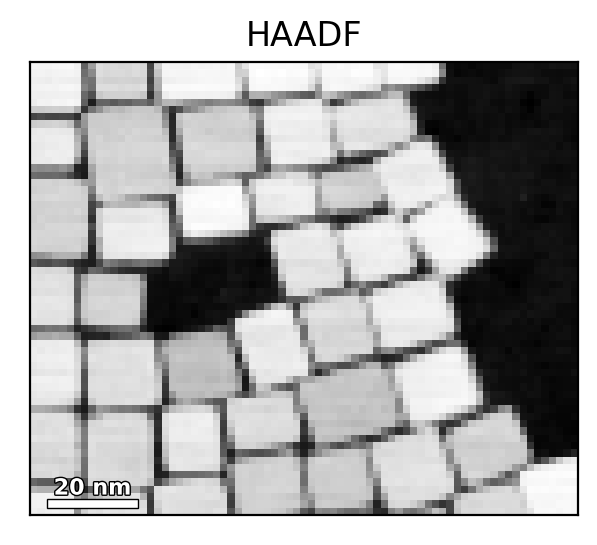

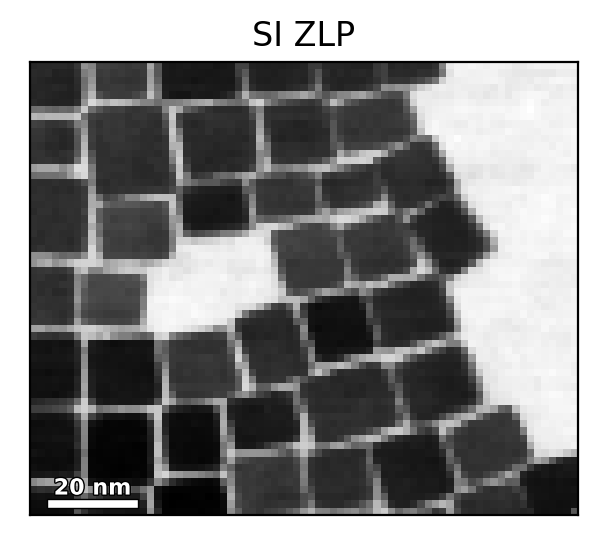

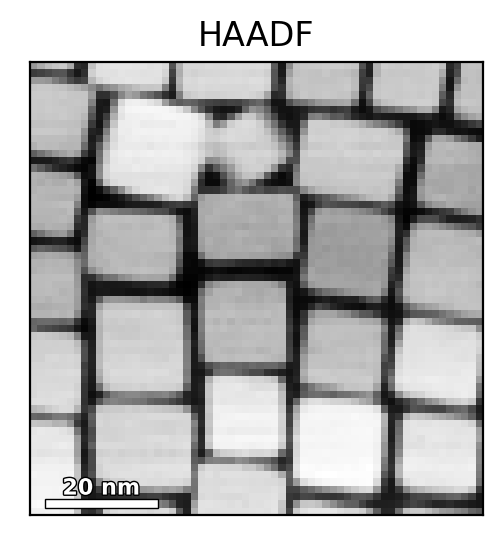

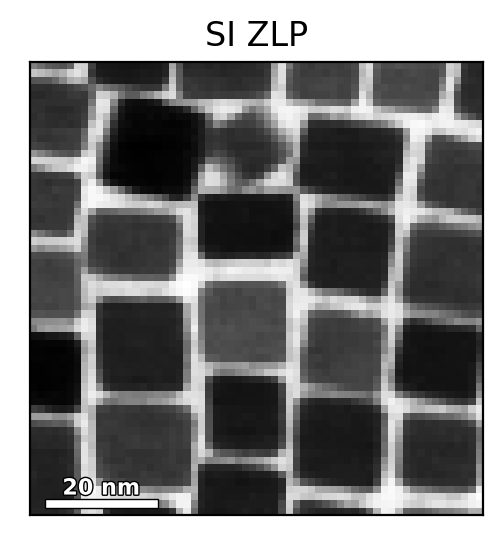

In [ ]:
#@title Load and Display Data
filename='/content/HAADF_FITO0_array_edgewithgap.npy'
SI1_imdat,SI1_imcal=LoadImage(filename)

DisplayImage(SI1_imdat,SI1_imcal,scale=20,title='HAADF')

filename='/content/SI_FITO0_array_edgewithgap.npy'
SI1_dat,SI1_cal,SI1_disp=LoadEELS_SI(filename)

Display_SI(SI1_dat,SI1_cal,scale=20,title='SI ZLP')

filename='/content/HAADF_FITO0_array4x4.npy'
SI2_imdat,SI2_imcal=LoadImage(filename)

DisplayImage(SI2_imdat,SI2_imcal,scale=20,title='HAADF')

filename='/content/SI_FITO0_array4x4.npy'
SI2_dat,SI2_cal,SI2_disp=LoadEELS_SI(filename)

Display_SI(SI2_dat,SI2_cal,scale=20,title='SI ZLP')


(-0.05, 0.05)

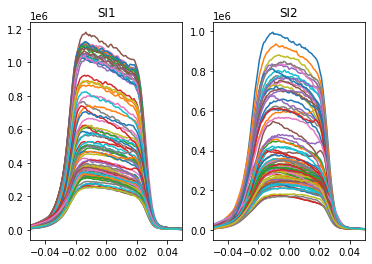

In [ ]:
#@title Preprocessing: Calibrate Hyperspectral Datasets

# Choose Energy Axis for Calibration

en_lo=-0.075;en_hi=2.0

# Generate Calibrated Energy Axes
SI1_Ens=GetSIEnergyAxes(SI1_dat,SI1_disp)
SI2_Ens=GetSIEnergyAxes(SI2_dat,SI2_disp)

# Generate Calibrated SIs on Single Energy Axis
E1,SI1=GetCalibratedSI(SI1_dat,SI1_Ens,en_lo,en_hi)
E2,SI2=GetCalibratedSI(SI2_dat,SI2_Ens,en_lo,en_hi)

# Check that alignment and calibration has worked properly
# If all ZLPs are not well aligned on one another try to play around with options in GetSIEnergyAxes

f,a=plt.subplots(1,2)
for n in range(100):
    i1,j1=np.random.randint(SI1.shape[0]),np.random.randint(SI1.shape[1])
    i2,j2=np.random.randint(SI2.shape[0]),np.random.randint(SI2.shape[1])
    a[0].plot(E1,SI1[i1,j1])
    a[1].plot(E2,SI2[i2,j2])
a[0].set_title('SI1')
a[1].set_title('SI2')
a[0].set_xlim(-0.05,0.05)
a[1].set_xlim(-0.05,0.05)

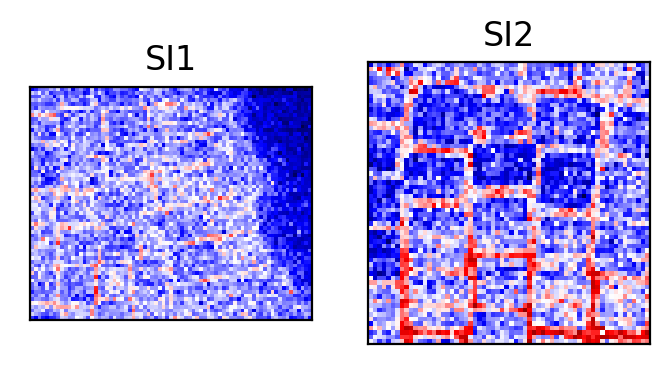

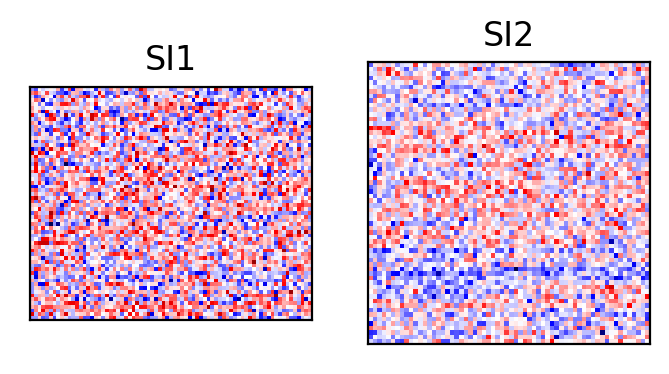

In [ ]:
#@title Preprocessing: Normalize Dark Reference to Zero

# If any part of images are significantly negative (blue) on average set NormalizeBKG=True
NormalizeBKG=True

i1=-20;i2=-1
SI1tail=np.average(SI1[:,:,i1:i2],axis=2)
SI2tail=np.average(SI2[:,:,i1:i2],axis=2)

f,a=plt.subplots(1,2,dpi=200,figsize=(4,3))
a[0].imshow(SI1tail,cmap=cm.seismic,vmin=-np.amax(np.abs(SI1tail)),vmax=np.amax(np.abs(SI1tail)))
a[0].set_title("SI1")
a[1].imshow(SI2tail,cmap=cm.seismic,vmin=-np.amax(np.abs(SI2tail)),vmax=np.amax(np.abs(SI2tail)))
a[1].set_title("SI2")
a[0].set_xticks([]),a[0].set_yticks([])
a[1].set_xticks([]),a[1].set_yticks([])

if NormalizeBKG: 
  SI1=np.asarray([[ZeroSpectrum_ToRan(s,-50,-1) for s in row] for row in SI1])
  SI2=np.asarray([[ZeroSpectrum_ToRan(s,-50,-1) for s in row] for row in SI2])

  SI1tail=np.average(SI1[:,:,i1:i2],axis=2)
  SI2tail=np.average(SI2[:,:,i1:i2],axis=2)

  f,a=plt.subplots(1,2,dpi=200,figsize=(4,3))
  a[0].imshow(SI1tail,cmap=cm.seismic,vmin=-np.amax(np.abs(SI1tail)),vmax=np.amax(np.abs(SI1tail)))
  a[0].set_title("SI1")
  a[1].imshow(SI2tail,cmap=cm.seismic,vmin=-np.amax(np.abs(SI2tail)),vmax=np.amax(np.abs(SI2tail)))
  a[1].set_title("SI2")
  a[0].set_xticks([]),a[0].set_yticks([])
  a[1].set_xticks([]),a[1].set_yticks([])


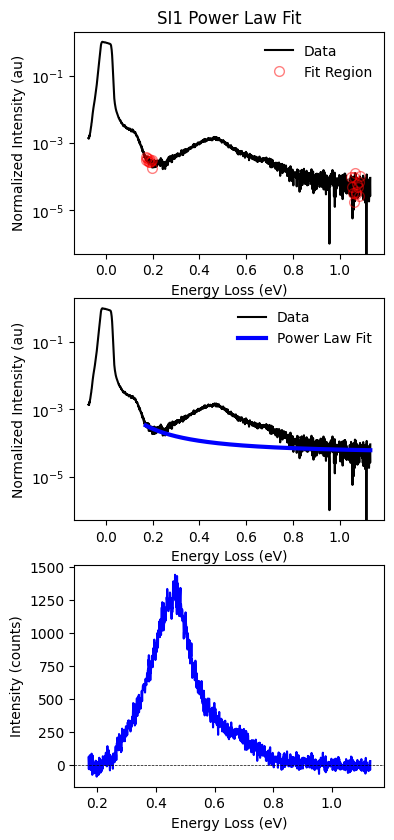

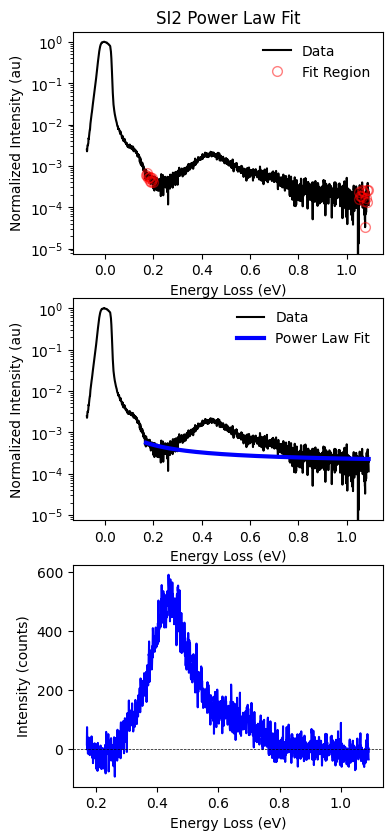

In [ ]:
#@title Preprocessing: Power Law Background Subtraction

#Define energy range for Power Law background fit
#Adjust fit regions until decent match is achieved at both the low and high energy ends of the spectra
fit_EL0=0.17;fit_EL1=0.2
fit_EH0=1.05;fit_EH1=1.09

i,j=np.random.randint(SI1.shape[0]),np.random.randint(SI1.shape[1])
out=FitPowerlaw2R(E1,SI1[i,j],fit_EL0,fit_EL1,fit_EH0,fit_EH1,title='SI1 Power Law Fit')

i,j=np.random.randint(SI2.shape[0]),np.random.randint(SI2.shape[1])
out=FitPowerlaw2R(E2,SI2[i,j],fit_EL0,fit_EL1,fit_EH0,fit_EH1,title='SI2 Power Law Fit')

E1_NB,BG1_NB,SI1_NB=FitPowerlaw2R_SI(E1,SI1,fit_EL0,fit_EL1,fit_EH0,fit_EH1)
E2_NB,BG2_NB,SI2_NB=FitPowerlaw2R_SI(E2,SI2,fit_EL0,fit_EL1,fit_EH0,fit_EH1)

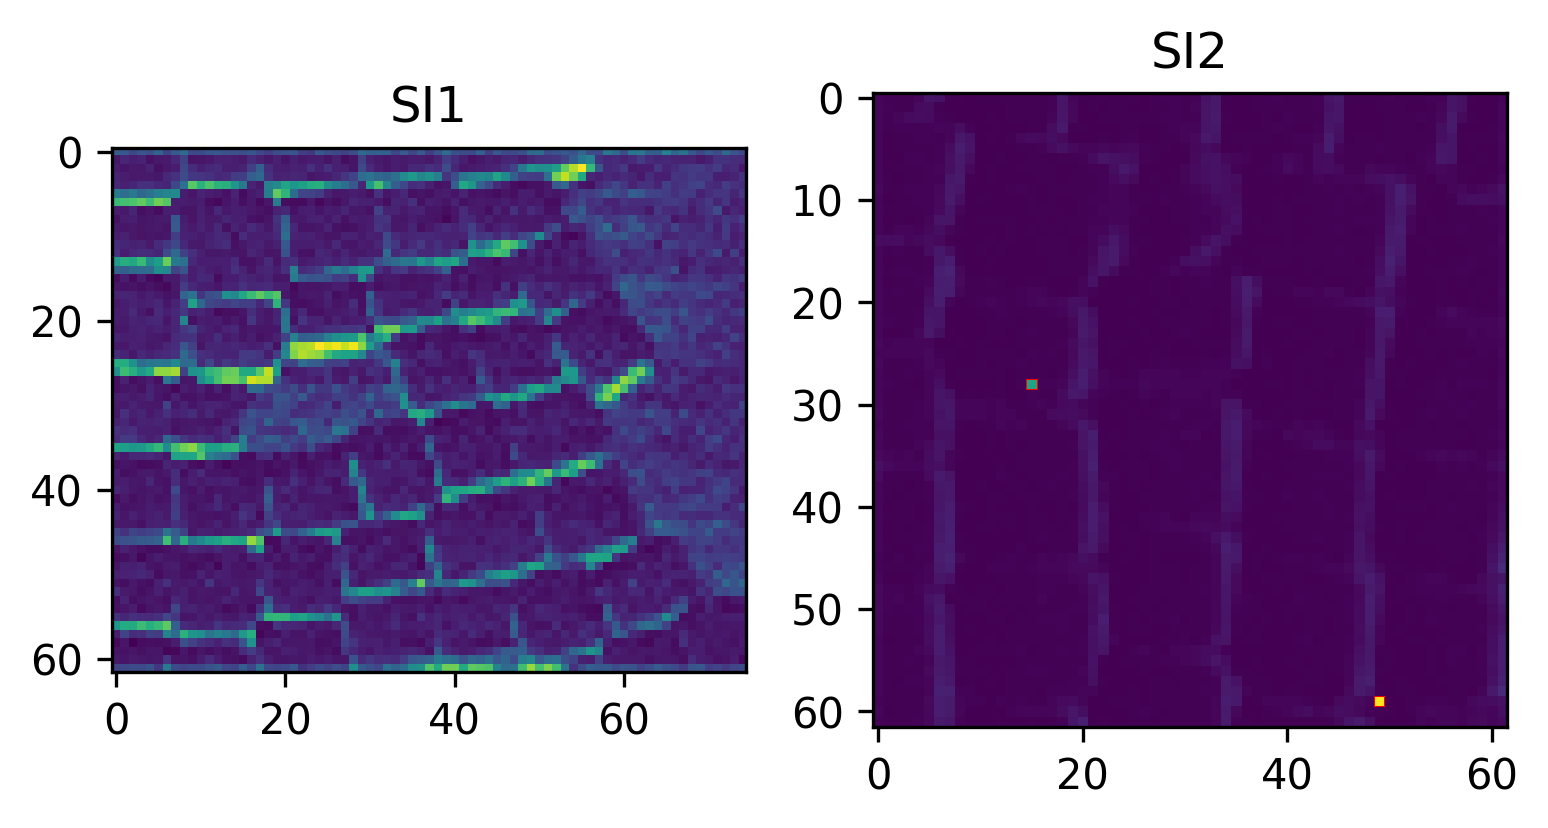

In [ ]:
#@title Preprocessing: Check for x-Ray spectrometer channel defects

#Stray x-rays can generate point blemishes in spectra that hinder DL analysis, they must
#be manually removed before analysis. Check by looking at the maximum gradient in the
#spectral axis of the hyperspectral dataset

gradSI1=np.asarray(np.gradient(SI1_NB,axis=(0,1)))
gradSI2=np.asarray(np.gradient(SI2_NB,axis=(0,1)))

#If point blemishes detected add pixel coordinates here so that they are highlighted
#for removal. Here there are none in SI1 and two in SI2.
SI1_Rs=[]
SI2_Rs=[[28,16],[59,50]]

f,a=plt.subplots(1,2,dpi=300)
a[0].imshow(np.amax(gradSI1[0],axis=2))
a[0].set_title('SI1')
for r in SI1_Rs: a[0].add_patch(Rectangle((r[1]-1-0.5,r[0]-0.5),1,1,fc='None',ec='r',lw=0.25))
a[1].imshow(np.amax(gradSI2[1],axis=2))
a[1].set_title('SI2')
for r in SI2_Rs: a[1].add_patch(Rectangle((r[1]-1-0.5,r[0]-0.5),1,1,fc='None',ec='r',lw=0.25))


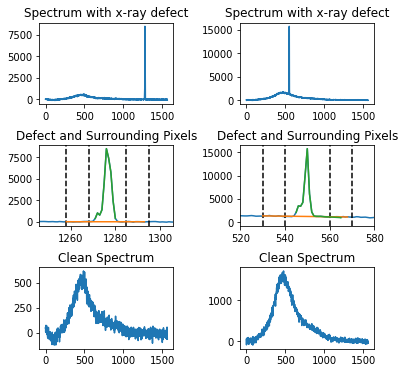

In [ ]:
#@title Preprocessing: Remove x-Ray spectrometer channel defects 

#Define spectrometer used to average out x-ray defect
left=[[1258,1268],[530,540]]
right=[[1285,1295],[560,570]]

Nbad=len(SI2_Rs)
f,a=plt.subplots(3,Nbad,figsize=(6,Nbad*3))
t=100
for i in range(Nbad):
  badspec=SI2_NB[SI2_Rs[i][0],SI2_Rs[i][1]]
  a[0,i].plot(badspec)
  a[0,i].set_title('Spectrum with x-ray defect')
  a[1,i].plot(badspec)
  badpix=np.argmax(badspec)
  a[1,i].set_xlim(badpix-30,badpix+30)
  a[1,i].axvline(left[i][0],color='k',ls='--')
  a[1,i].axvline(left[i][1],color='k',ls='--')
  a[1,i].axvline(right[i][0],color='k',ls='--')
  a[1,i].axvline(right[i][1],color='k',ls='--')
  lran,rran=np.arange(left[i][0],left[i][1]),np.arange(right[i][0],right[i][1])
  ldat,rdat=badspec[left[i][0]:left[i][1]],badspec[right[i][0]:right[i][1]]
  fran,fdat=np.append(lran,rran),np.append(ldat,rdat)
  r,A=np.polyfit(fran,fdat,1)
  iran=np.arange(lran[0],rran[-1])
  fitdat=r*iran+A
  a[1,i].plot(iran,fitdat)
  baddata=np.where(np.abs(badspec[lran[0]:rran[-1]]-fitdat)>t)
  a[1,i].plot(iran[baddata],badspec[lran[0]:rran[-1]][baddata])
  a[1,i].set_title('Defect and Surrounding Pixels')
  ################################################################################
  #### Leave this line commented until you've determined your parameters
  SI2_NB[SI2_Rs[i][0],SI2_Rs[i][1]][lran[0]:rran[-1]][baddata]=fitdat[baddata]
  ################################################################################
  goodspec=SI2_NB[SI2_Rs[i][0],SI2_Rs[i][1]]
  a[2,i].plot(goodspec)
  a[2,i].set_title('Clean Spectrum')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

In [ ]:
#@title Preprocessing: Define Single Energy Axis for both Datasets 
#This step enables direct comparison between the datasets.

N_spec=3000

ENB_0=np.amax([E1_NB[0],E2_NB[0]])
ENB_1=np.amin([E1_NB[-1],E2_NB[-1]])
E=np.linspace(ENB_0,ENB_1,N_spec,endpoint=True)

SI1f=np.asarray([[AlignSpectrumtoEnergyAxis(E,E1_NB,s) for s in row] for row in SI1_NB])
SI2f=np.asarray([[AlignSpectrumtoEnergyAxis(E,E2_NB,s) for s in row] for row in SI2_NB])

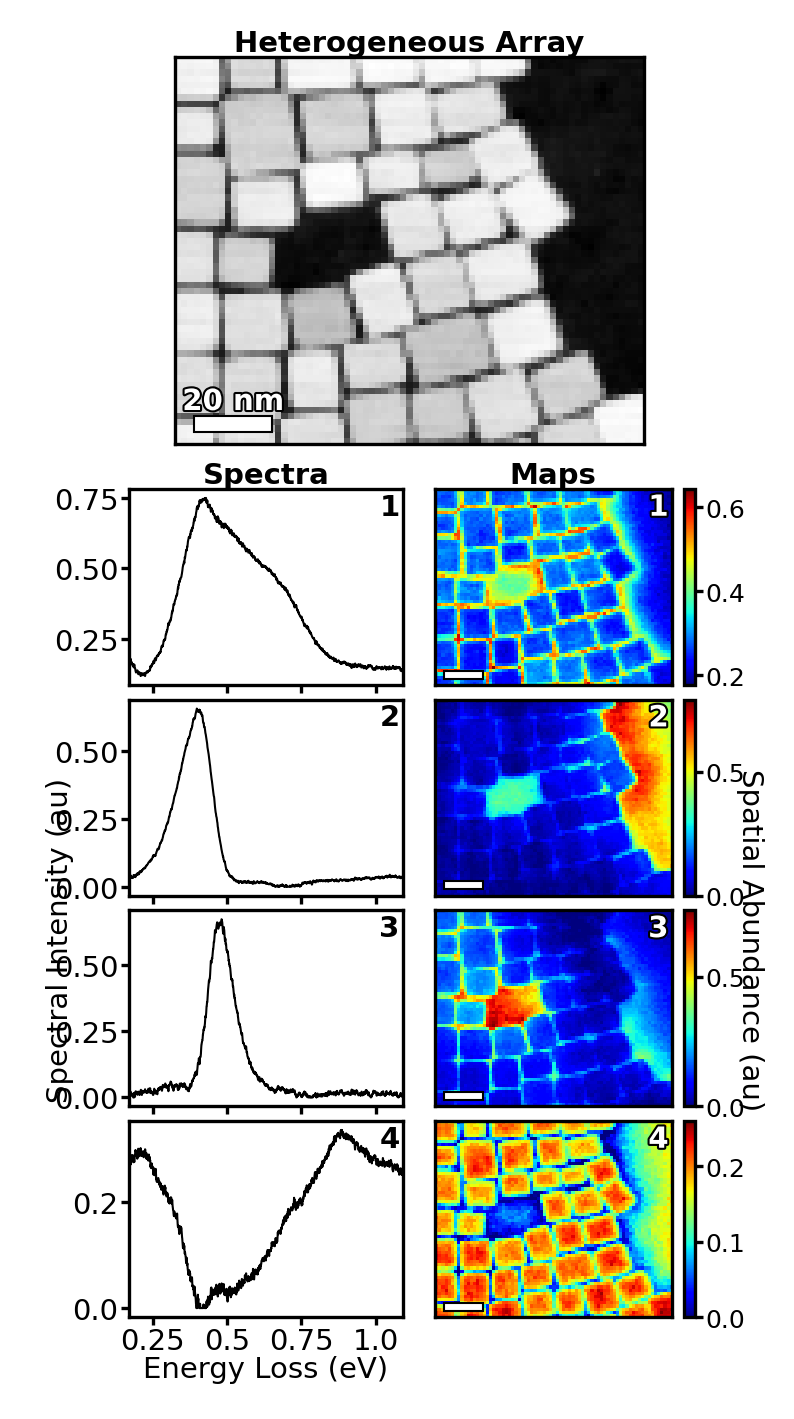

In [ ]:
#@title Data Exploration: Simple NMF Decomposition 

#Select Dataset
Use_SI=SI1f
Use_Im=SI1_imdat
Use_cal=SI1_imcal
Use_title='Heterogeneous Array'
Use_scale=20

#Select Number of NMF Components
n_comp = 4 

#Run decomposition
NMFdat = np.copy(Use_SI)
NMFdat=(NMFdat-np.amin(NMFdat))/np.ptp(NMFdat)
d1, d2, d3 = NMFdat.shape
NMFdat_flat = NMFdat.reshape(d1*d2, d3)
clf = NMF(n_components=n_comp, random_state=42)
NMF_maps = clf.fit_transform(NMFdat_flat)
NMF_maps = NMF_maps.reshape((d1,d2,n_comp))
NMF_spectra = clf.components_

#Visualize decomposition
fig=plt.figure(figsize=(2.2,0.75*n_comp),dpi=300)
a=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
a.text(0.025,0.5,'Spectral Intensity (au)',fontsize=7,rotation=90,va='center')
a.text(1.07,0.5,'Spatial Abundance (au)',fontsize=7,rotation=270,va='center')
a.set_axis_off()

a=fig.add_axes([0.15,1.05,0.85,0.43],xticks=[],yticks=[])
a.imshow(Use_Im,cmap=cm.Greys_r)
a.set_title(Use_title,fontweight='bold',fontsize=7,va='top')
bar_w=Use_scale/Use_cal;bar_h=bar_w/5.
a.add_patch(Rectangle((bar_h,d1-2*bar_h),bar_w,bar_h,fc='w',ec='k',lw=0.5))
txt=a.text(bar_h+bar_w/2.,d1-2*bar_h,str(Use_scale)+' nm',color='w',fontweight='bold',fontsize=7,ha='center',va='bottom')
txt.set_path_effects([pe.withStroke(linewidth=1.0,foreground='k')])

for i in range(n_comp):
  a=fig.add_subplot(n_comp,2,2*i+2,xticks=[],yticks=[])
  im=a.imshow(NMF_maps[:,:,i],cmap=cm.jet)
  txt=a.text(d2*0.98,1,str(i+1),color='w',fontweight='bold',fontsize=7,ha='right',va='top')
  txt.set_path_effects([pe.withStroke(linewidth=1.0,foreground='k')])
  if i==0: a.set_title('Maps',fontweight='bold',fontsize=7,va='top')
  a.add_patch(Rectangle((bar_h,d1-2*bar_h),bar_w,bar_h,fc='w',ec='k',lw=0.5))
  cbax = inset_axes(a,width="5%",height="100%",loc='lower left',
                    bbox_to_anchor=(1.05,0.,1,1),bbox_transform=a.transAxes,borderpad=0,)
  cbar=fig.colorbar(im, cax=cbax)
  cbar.ax.tick_params(labelsize=6,length=2,pad=0.5)  # vertically oriented colorbar
  
  a=fig.add_subplot(n_comp,2,2*i+1)
  a.plot(E, NMF_spectra[i],color='k',lw=0.5)
  a.set_xticklabels([])
  a.tick_params(labelsize=7,length=2,pad=0.5)
  ym,yM=a.get_ylim()
  a.text(E[-1]-0.01,yM*0.98,str(i+1),fontweight='bold',fontsize=7,ha='right',va='top')
  a.set_xticks([0.25,0.5,0.75,1.0])
  a.set_xlim(E[0],E[-1])
  if i==0: a.set_title('Spectra',fontweight='bold',fontsize=7,va='top')
a.set_xticklabels([0.25,0.5,0.75,1.0])
a.set_xlabel('Energy Loss (eV)',fontsize=7,labelpad=0)
plt.subplots_adjust(bottom=0.08,top=1,right=1,left=0.15,wspace=0.05,hspace=0.075)

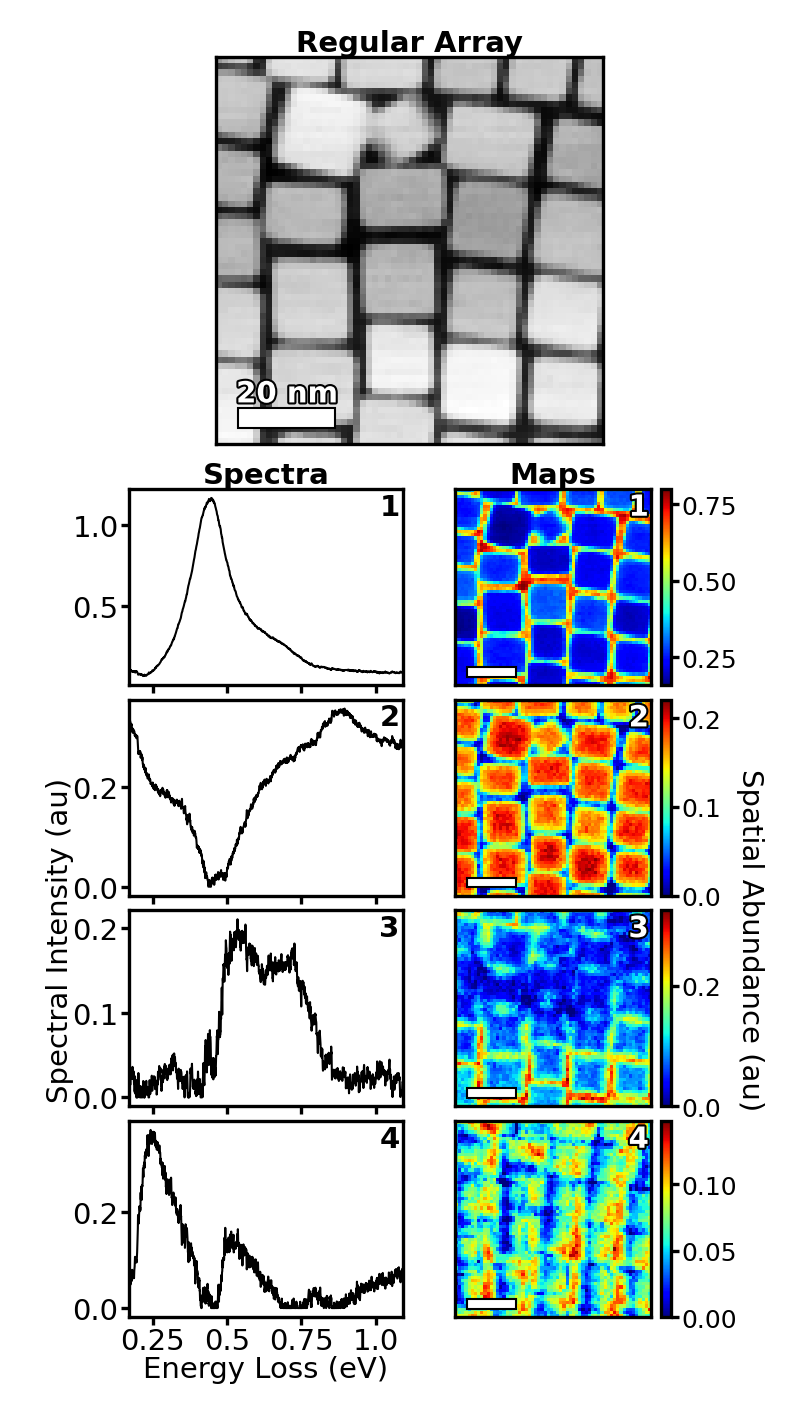

In [ ]:
#@title Data Exploration: Simple NMF Decomposition 

#Select Dataset
Use_SI=SI2f
Use_Im=SI2_imdat
Use_cal=SI2_imcal
Use_title='Regular Array'
Use_scale=20

#Select Number of NMF Components
n_comp = 4 

#Run decomposition
NMFdat = np.copy(Use_SI)
NMFdat=(NMFdat-np.amin(NMFdat))/np.ptp(NMFdat)
d1, d2, d3 = NMFdat.shape
NMFdat_flat = NMFdat.reshape(d1*d2, d3)
clf = NMF(n_components=n_comp, random_state=42)
NMF_maps = clf.fit_transform(NMFdat_flat)
NMF_maps = NMF_maps.reshape((d1,d2,n_comp))
NMF_spectra = clf.components_

#Visualize decomposition
fig=plt.figure(figsize=(2.2,0.75*n_comp),dpi=300)
a=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
a.text(0.025,0.5,'Spectral Intensity (au)',fontsize=7,rotation=90,va='center')
a.text(1.07,0.5,'Spatial Abundance (au)',fontsize=7,rotation=270,va='center')
a.set_axis_off()

a=fig.add_axes([0.15,1.05,0.85,0.43],xticks=[],yticks=[])
a.imshow(Use_Im,cmap=cm.Greys_r)
a.set_title(Use_title,fontweight='bold',fontsize=7,va='top')
bar_w=Use_scale/Use_cal;bar_h=bar_w/5.
a.add_patch(Rectangle((bar_h,d1-2*bar_h),bar_w,bar_h,fc='w',ec='k',lw=0.5))
txt=a.text(bar_h+bar_w/2.,d1-2*bar_h,str(Use_scale)+' nm',color='w',fontweight='bold',fontsize=7,ha='center',va='bottom')
txt.set_path_effects([pe.withStroke(linewidth=1.0,foreground='k')])

for i in range(n_comp):
  a=fig.add_subplot(n_comp,2,2*i+2,xticks=[],yticks=[])
  im=a.imshow(NMF_maps[:,:,i],cmap=cm.jet)
  txt=a.text(d2*0.98,1,str(i+1),color='w',fontweight='bold',fontsize=7,ha='right',va='top')
  txt.set_path_effects([pe.withStroke(linewidth=1.0,foreground='k')])
  if i==0: a.set_title('Maps',fontweight='bold',fontsize=7,va='top')
  a.add_patch(Rectangle((bar_h,d1-2*bar_h),bar_w,bar_h,fc='w',ec='k',lw=0.5))
  cbax = inset_axes(a,width="5%",height="100%",loc='lower left',
                    bbox_to_anchor=(1.05,0.,1,1),bbox_transform=a.transAxes,borderpad=0,)
  cbar=fig.colorbar(im, cax=cbax)
  cbar.ax.tick_params(labelsize=6,length=2,pad=0.5)  # vertically oriented colorbar
  
  a=fig.add_subplot(n_comp,2,2*i+1)
  a.plot(E,NMF_spectra[i],color='k',lw=0.5)
  a.set_xticklabels([])
  a.tick_params(labelsize=7,length=2,pad=0.5)
  ym,yM=a.get_ylim()
  a.text(E[-1]-0.01,yM*0.98,str(i+1),fontweight='bold',fontsize=7,ha='right',va='top')
  a.set_xticks([0.25,0.5,0.75,1.0])
  a.set_xlim(E[0],E[-1])
  if i==0: a.set_title('Spectra',fontweight='bold',fontsize=7,va='top')
a.set_xticklabels([0.25,0.5,0.75,1.0])
a.set_xlabel('Energy Loss (eV)',fontsize=7,labelpad=0)
plt.subplots_adjust(bottom=0.08,top=1,right=1,left=0.15,wspace=0.05,hspace=0.075)

[]

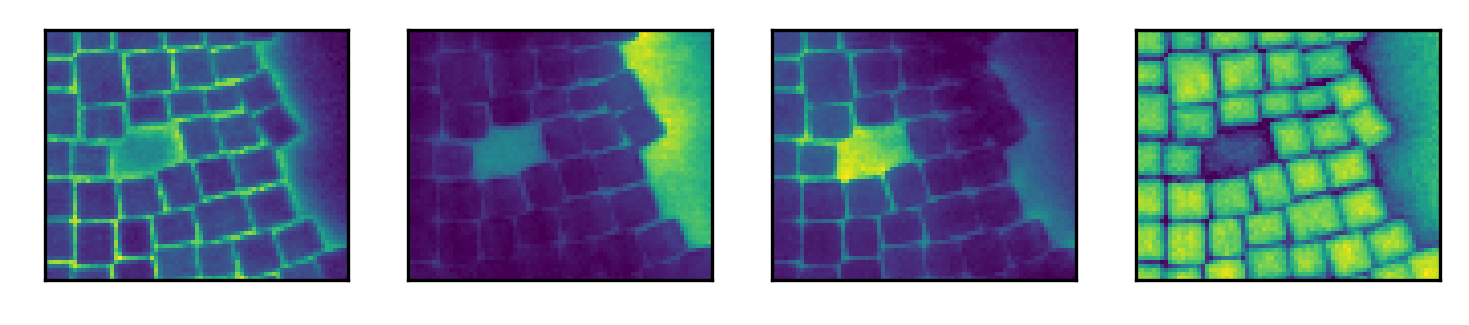

In [ ]:
#@title Supervised Label Propagation: NMF Decomposition to Aid Operator Labeling

#Select Dataset
Use_SI=SI1f

#Select Number of NMF Components: Adjust such that different regions are highlighted
#by different NMF components. We will then use thresholds to label regions in the NMF maps
n_comp = 4 

#Run decomposition
NMFdat = np.copy(Use_SI)
NMFdat=(NMFdat-np.amin(NMFdat))/np.ptp(NMFdat)
d1, d2, d3 = NMFdat.shape
NMFdat_flat = NMFdat.reshape(d1*d2, d3)
clf = NMF(n_components=n_comp, random_state=42)
NMF_maps = clf.fit_transform(NMFdat_flat)
NMF_maps = NMF_maps.reshape((d1,d2,n_comp))
NMF_spectra = clf.components_
yy,xx=np.mgrid[0:d1,0:d2]

f,a=plt.subplots(1,n_comp,dpi=300)
for i in range(n_comp): a[i].imshow(NMF_maps[:,:,i])
plt.setp(a,xticks=[],yticks=[])

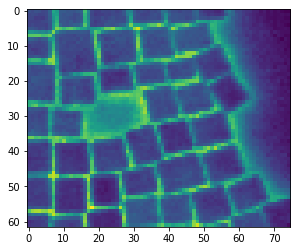

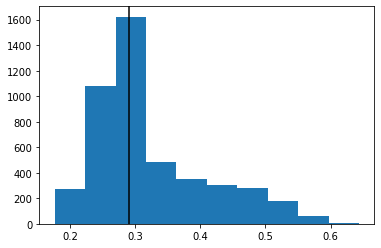

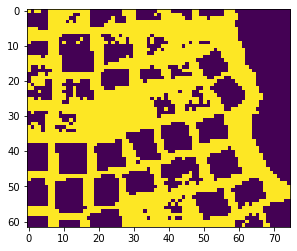

In [ ]:
#@title Supervised Label Propagation: Label Region (Array Gaps - Total Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,0]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.29
plt.axvline(threshold,color='k')
plt.show()

mask_array_gaps=Use_comp>threshold

plt.imshow(mask_array_gaps)
plt.show()

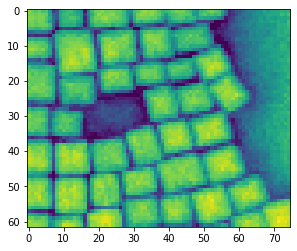

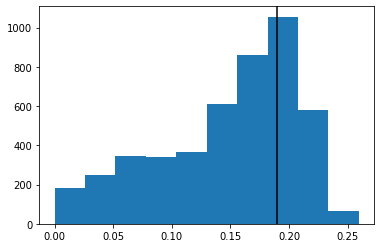

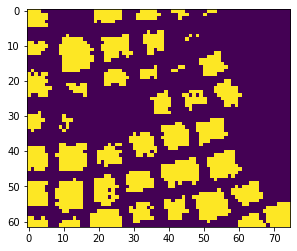

In [ ]:
#@title Supervised Label Propagation: Label Region (Particle Centers - Total Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,3]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.19
plt.axvline(threshold,color='k')
plt.show()

mask_particle_centers=Use_comp>threshold

plt.imshow(mask_particle_centers)
plt.show()

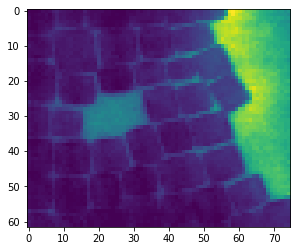

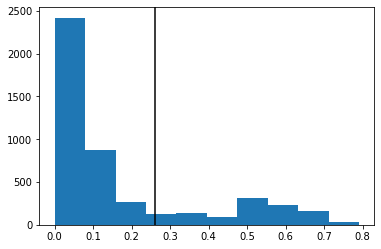

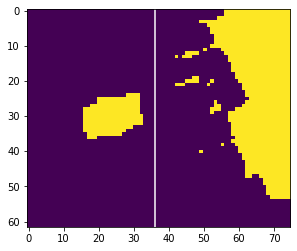

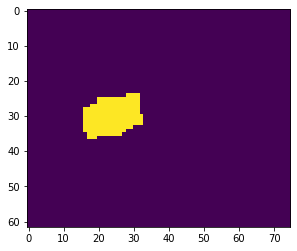

In [ ]:
#@title Supervised Label Propagation: Label Region (Array Hole - Total Labeling)

#Use thresholds of NMF map intensity and pixel positions to define region
Use_comp=NMF_maps[:,:,1]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.26
plt.axvline(threshold,color='k')
plt.show()

mask_array_hole=Use_comp>threshold
x_threshold=36
plt.imshow(mask_array_hole)
plt.axvline(x_threshold,color='w')
plt.show()

mask_array_hole=mask_array_hole & (xx<x_threshold)
plt.imshow(mask_array_hole)
plt.show()

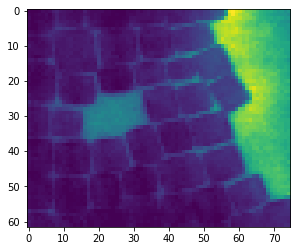

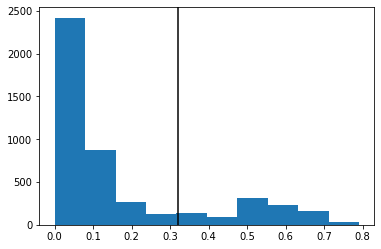

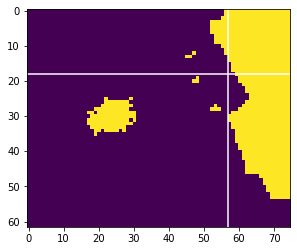

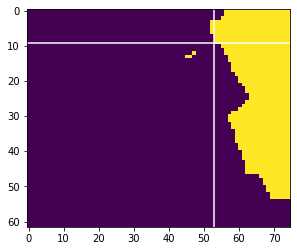

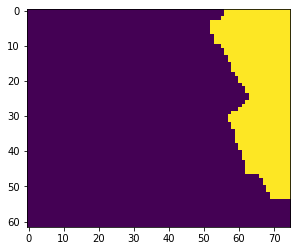

In [ ]:
#@title Supervised Label Propagation: Label Region (Outside - Total Labeling)

#Use thresholds of NMF map intensity and pixel positions to define region
Use_comp=NMF_maps[:,:,1]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.32
plt.axvline(threshold,color='k')
plt.show()

mask_outside=Use_comp>threshold

plt.imshow(mask_outside)
x_threshold=57
y_threshold=18
plt.axvline(x_threshold,color='w')
plt.axhline(y_threshold,color='w')
plt.show()

mask_outside=mask_outside & ~((xx<x_threshold) & (yy>y_threshold))
plt.imshow(mask_outside)
x_threshold=53
y_threshold=9
plt.axvline(x_threshold,color='w')
plt.axhline(y_threshold,color='w')
plt.show()

mask_outside=mask_outside & ~((xx<x_threshold) & (yy>y_threshold))
plt.imshow(mask_outside)
plt.show()

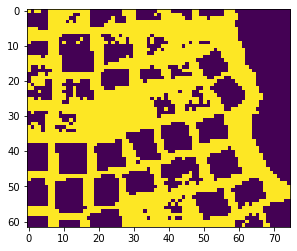

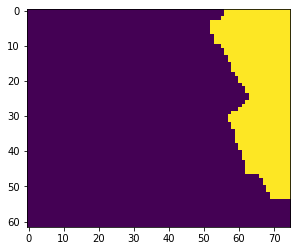

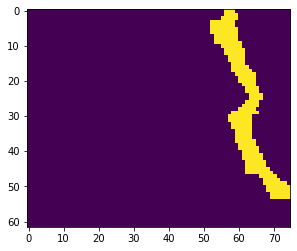

In [ ]:
#@title Supervised Label Propagation: Label Region (Array Edge - Total Labeling)

#Use overlap between multiple maps to define region we deliberately set the threshold
#too low on this one so it fills in all the gaps then refine it later
Use_comp=mask_array_gaps
plt.imshow(Use_comp)
plt.show()

mask_overlapping=mask_outside
plt.imshow(mask_overlapping)
plt.show()

mask_array_edge=Use_comp & mask_overlapping
plt.imshow(mask_array_edge)
plt.show()

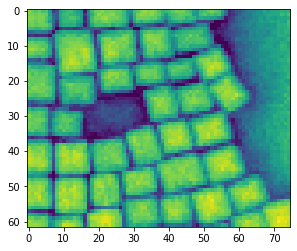

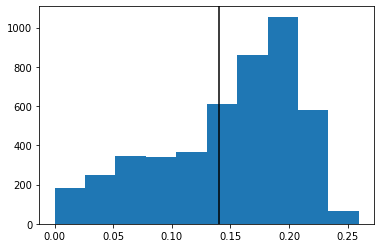

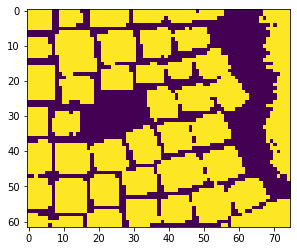

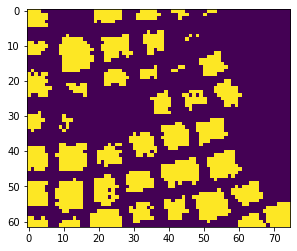

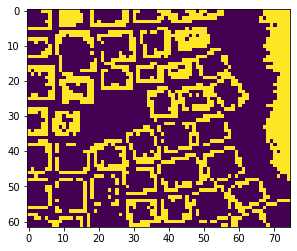

In [ ]:
#@title Supervised Label Propagation: Label Region (Particle Edges - Total Labeling)

#Use overlap between multiple maps to define region
Use_comp=NMF_maps[:,:,3]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.14
plt.axvline(threshold,color='k')
plt.show()

mask_particles_rough=Use_comp>threshold
plt.imshow(mask_particles_rough)
plt.show()

mask_overlapping=mask_particle_centers
plt.imshow(mask_overlapping)
plt.show()

mask_particle_edges=mask_particles_rough & ~mask_overlapping
plt.imshow(mask_particle_edges)
plt.show()


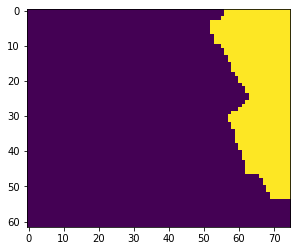

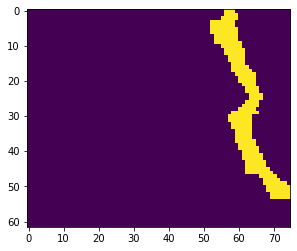

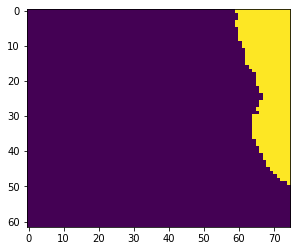

In [ ]:
#@title Supervised Label Propagation: Refine Label (Outside - Total Labeling)

#Use overlap between multiple maps to refine labeled region, to prevent pixel overlap
plt.imshow(mask_outside)
plt.show()

mask_overlap=mask_array_edge
plt.imshow(mask_overlap)
plt.show()

mask_outside_refined=mask_outside & ~mask_overlap
plt.imshow(mask_outside_refined)
plt.show()

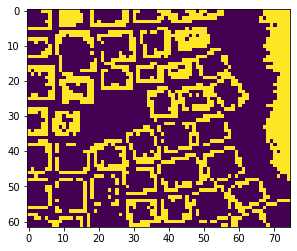

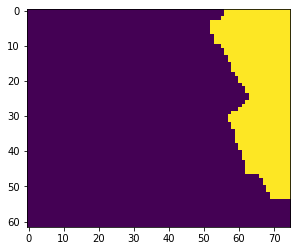

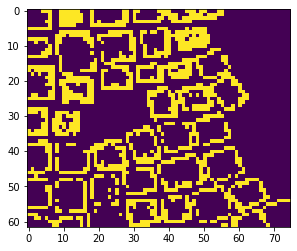

In [ ]:
#@title Supervised Label Propagation: Refine Label (Particle Edges - Total Labeling)

#Use overlap between multiple maps to refine labeled region, to prevent pixel overlap
plt.imshow(mask_particle_edges)
plt.show()

mask_overlap=mask_outside
plt.imshow(mask_overlap)
plt.show()

mask_particle_edges_refined=mask_particle_edges & ~mask_overlap
plt.imshow(mask_particle_edges_refined)
plt.show()


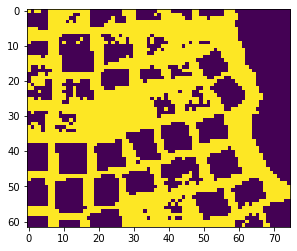

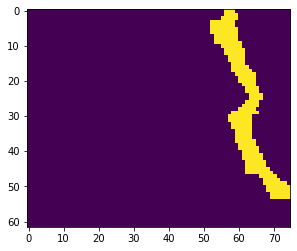

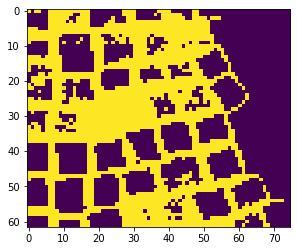

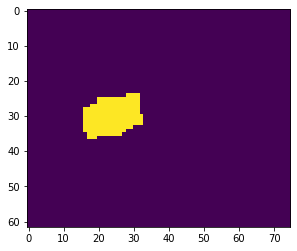

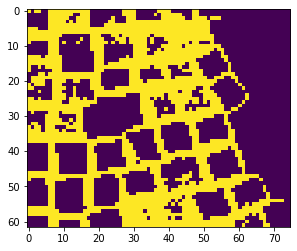

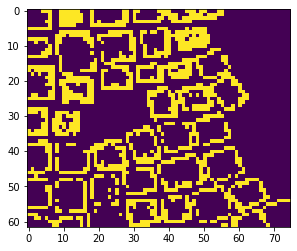

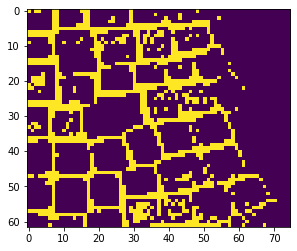

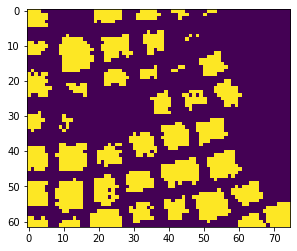

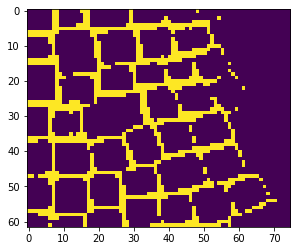

In [ ]:
#@title Supervised Label Propagation: Refine Label (Array Gaps - Total Labeling)

#Use overlap between multiple maps to refine labeled region, to prevent pixel overlap
plt.imshow(mask_array_gaps)
plt.show()

mask_overlap=mask_array_edge
plt.imshow(mask_overlap)
plt.show()

mask_array_gaps_refined=mask_array_gaps & ~mask_overlap
plt.imshow(mask_array_gaps_refined)
plt.show()

mask_overlap=mask_array_hole
plt.imshow(mask_overlap)
plt.show()

mask_array_gaps_refined=mask_array_gaps_refined & ~mask_overlap
plt.imshow(mask_array_gaps_refined)
plt.show()

mask_overlap=mask_particle_edges_refined
plt.imshow(mask_overlap)
plt.show()

mask_array_gaps_refined=mask_array_gaps_refined & ~mask_overlap
plt.imshow(mask_array_gaps_refined)
plt.show()

mask_overlap=mask_particle_centers
plt.imshow(mask_overlap)
plt.show()

mask_array_gaps_refined=mask_array_gaps_refined & ~mask_overlap
plt.imshow(mask_array_gaps_refined)
plt.show()

(6, 62, 75)


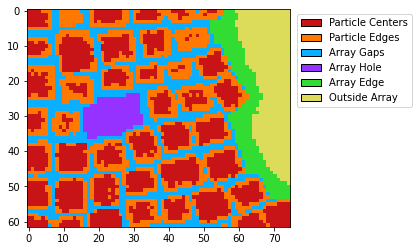

In [ ]:
#@title Supervised Label Propagation: Display Total Labeling
labels_total=[mask_particle_centers,mask_particle_edges_refined,mask_array_gaps_refined,mask_array_hole,mask_array_edge,mask_outside_refined]
comp_colors=[Red,Orange,Blue,Purple,Green,Yellow]
comp_labels=['Particle Centers','Particle Edges','Array Gaps','Array Hole','Array Edge','Outside Array']
comp_handles=[Rectangle((0,0),0,0,facecolor=c,ec='k') for c in comp_colors]

plt.imshow(MakeCompositeImage(labels_total,comp_colors))
plt.legend(comp_handles,comp_labels,loc='upper left',bbox_to_anchor=(1.01,1.0))

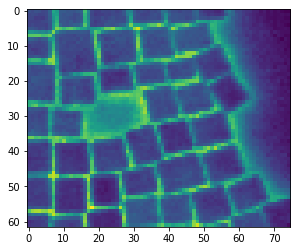

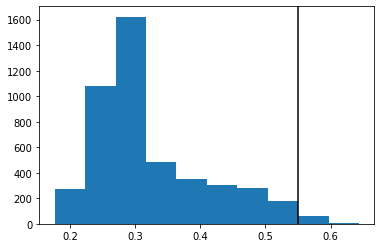

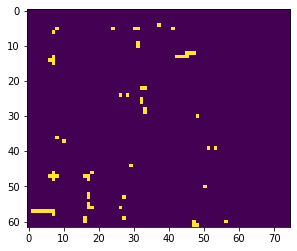

In [ ]:
#@title Supervised Label Propagation: Label Region (Array Gaps - Partial Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,0]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.55
plt.axvline(threshold,color='k')
plt.show()

pmask_array_gaps=Use_comp>threshold

plt.imshow(pmask_array_gaps)
plt.show()

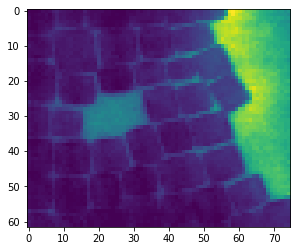

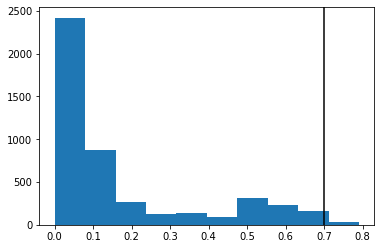

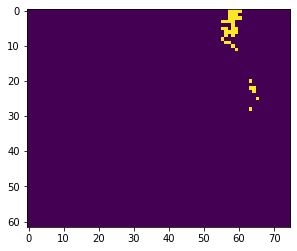

In [ ]:
#@title Supervised Label Propagation: Label Region (Array Edge - Partial Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,1]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.7
plt.axvline(threshold,color='k')
plt.show()

pmask_array_edge=Use_comp>threshold

plt.imshow(pmask_array_edge)
plt.show()

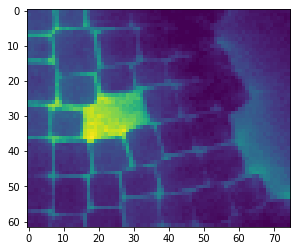

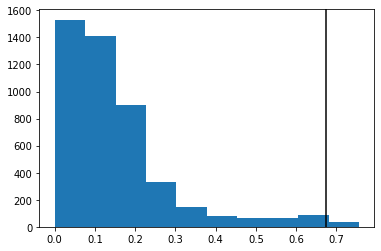

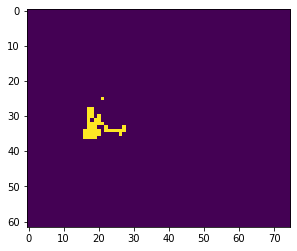

In [ ]:
#@title Supervised Label Propagation: Label Region (Array Hole - Partial Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,2]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.675
plt.axvline(threshold,color='k')
plt.show()

pmask_array_hole=Use_comp>threshold

plt.imshow(pmask_array_hole)
plt.show()

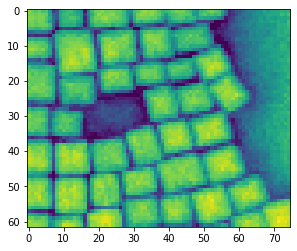

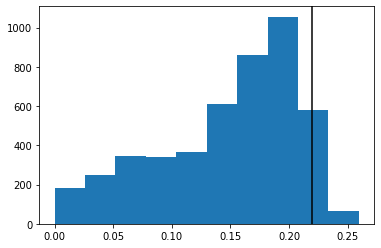

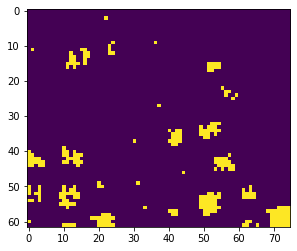

In [ ]:
#@title Supervised Label Propagation: Label Region (Particle Centers - Partial Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,3]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.22
plt.axvline(threshold,color='k')
plt.show()

pmask_particle_centers=Use_comp>threshold

plt.imshow(pmask_particle_centers)
plt.show()

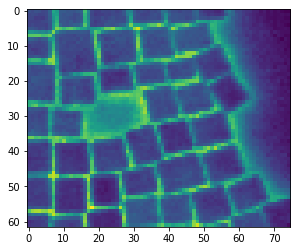

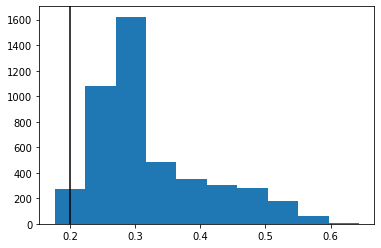

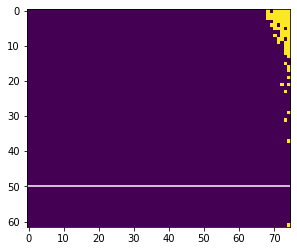

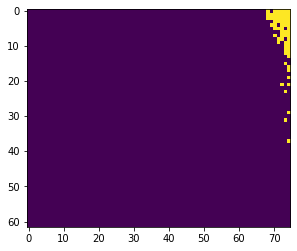

In [ ]:
#@title Supervised Label Propagation: Label Region (Outside - Partial Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,0]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold = 0.2
plt.axvline(threshold,color='k')
plt.show()

pmask_outside=Use_comp<threshold
plt.imshow(pmask_outside)
y_threshold=50
plt.axhline(y_threshold,color='w')
plt.show()

pmask_outside=pmask_outside & (yy<y_threshold)
plt.imshow(pmask_outside)
plt.show()

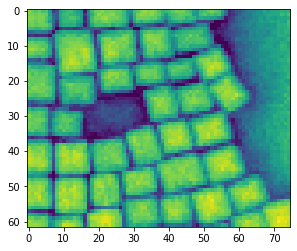

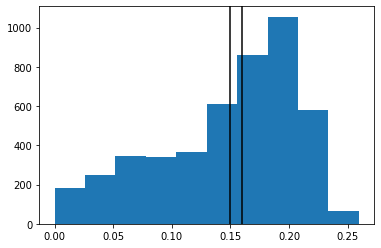

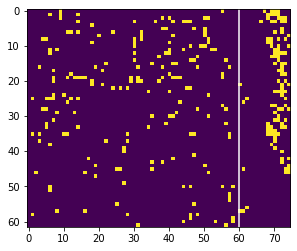

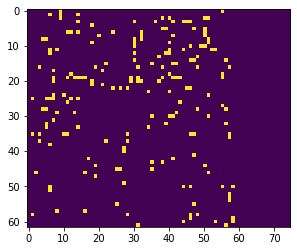

In [ ]:
#@title Supervised Label Propagation: Label Region (Particle Centers - Partial Labeling)

#Use NMF map intensity and thresholds to define region
Use_comp=NMF_maps[:,:,3]
plt.imshow(Use_comp)
plt.show()

plt.hist(Use_comp.reshape(d1*d2))
threshold_1 = 0.16
threshold_2 = 0.15
plt.axvline(threshold_1,color='k')
plt.axvline(threshold_2,color='k')
plt.show()


pmask_particle_edges=(Use_comp<=threshold_1) & (Use_comp>threshold_2)
plt.imshow(pmask_particle_edges)
x_threshold=60
plt.axvline(x_threshold,color='w')
plt.show()

pmask_particle_edges=pmask_particle_edges & (xx<x_threshold)
plt.imshow(pmask_particle_edges)
plt.show()

(6, 62, 75)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in true_divide


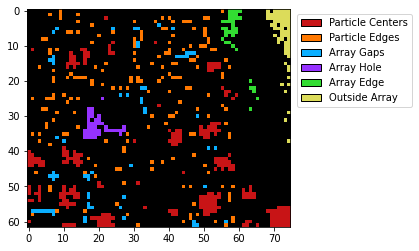

In [ ]:
#@title Supervised Label Propagation: Display Partial Labeling
labels_partial=[pmask_particle_centers,pmask_particle_edges,pmask_array_gaps,pmask_array_hole,pmask_array_edge,pmask_outside]
comp_colors=[Red,Orange,Blue,Purple,Green,Yellow]
comp_labels=['Particle Centers','Particle Edges','Array Gaps','Array Hole','Array Edge','Outside Array']
comp_handles=[Rectangle((0,0),0,0,facecolor=c,ec='k') for c in comp_colors]

plt.imshow(MakeCompositeImage(labels_partial,comp_colors))
plt.legend(comp_handles,comp_labels,loc='upper left',bbox_to_anchor=(1.01,1.0))

[]

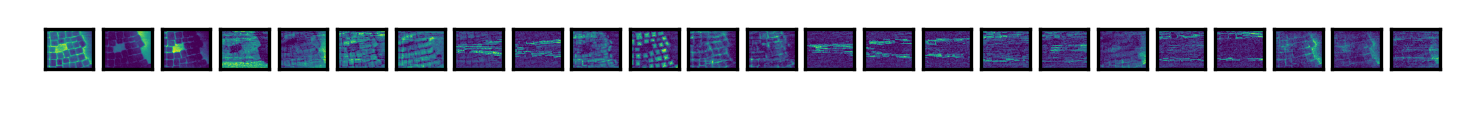

In [ ]:
#@title Supervised Label Propagation: NMF Decomposition for Label Propagation 

#Select Dataset
Use_SI=SI1f
Use_cal=SI1_imcal
Use_scale=20

#Select Number of NMF Components: Here use a high number of components to capture
#the most physical response present in the dataset possible. 
n_comp = 24 

#Run decomposition
NMFdat = np.copy(Use_SI)
NMFdat=(NMFdat-np.amin(NMFdat))/np.ptp(NMFdat)
d1, d2, d3 = NMFdat.shape
NMFdat_flat = NMFdat.reshape(d1*d2, d3)
clf = NMF(n_components=n_comp, random_state=42)
NMF_maps = clf.fit_transform(NMFdat_flat)
NMF_spectra = clf.components_
yy,xx=np.mgrid[0:d1,0:d2]

f,a=plt.subplots(1,n_comp,dpi=300)
for i in range(n_comp): a[i].imshow(NMF_maps[:,i].reshape((d1,d2)))
plt.setp(a,xticks=[],yticks=[])

In [ ]:
#@title Supervised Label Propagation: Prepare Dataset for Label Propagation (Total Labeling)

#Select labels
Use_labels=labels_total

#Remove all unlabeled pixels
n_label=len(Use_labels)
DL_data=[]
DL_labels=[]
Use_data = NMF_maps
Use_labels_reshaped = np.array(Use_labels).reshape((n_label,d1*d2)).T
for dat, labs in zip(Use_data,Use_labels_reshaped):
    if all(np.unique(labs) == np.array([0., 1.])):
        DL_labels.append(labs)
        DL_data.append(dat)
DL_data=np.asarray(DL_data);DL_labels=np.asarray(DL_labels)
DL_data.shape,DL_labels.shape

#Define Train/Test Data
dat_train,dat_test,lab_train,lab_test = train_test_split(DL_data, DL_labels, test_size=0.2, random_state=1)

In [ ]:
#@title Supervised Label Propagation: Create Network and Train on Labeled Data

model = Sequential()
model.add(Dense(30, activation='tanh', input_dim=dat_train.shape[1]))
model.add(Dense(30, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(30, activation='tanh',))

model.add(Dense(n_label, activation='softmax'))

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
#model.summary()
history = model.fit(
    dat_train, lab_train, validation_data=(dat_test, lab_test),
    epochs=200, batch_size=32, verbose=1, shuffle=True)

Epoch 1/200
117/117 [==============================] - 0s 3ms/step - loss: 1.2040 - accuracy: 0.5836 - val_loss: 0.6181 - val_accuracy: 0.7581
Epoch 2/200
117/117 [==============================] - 0s 2ms/step - loss: 0.4810 - accuracy: 0.8116 - val_loss: 0.4094 - val_accuracy: 0.8452
Epoch 3/200
117/117 [==============================] - 0s 2ms/step - loss: 0.3394 - accuracy: 0.8825 - val_loss: 0.3042 - val_accuracy: 0.8978
Epoch 4/200
117/117 [==============================] - 0s 2ms/step - loss: 0.2590 - accuracy: 0.9097 - val_loss: 0.2275 - val_accuracy: 0.9183
Epoch 5/200
117/117 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9328 - val_loss: 0.2679 - val_accuracy: 0.8968
Epoch 6/200
117/117 [==============================] - 0s 1ms/step - loss: 0.1769 - accuracy: 0.9374 - val_loss: 0.1789 - val_accuracy: 0.9280
Epoch 7/200
117/117 [==============================] - 0s 1ms/step - loss: 0.1604 - accuracy: 0.9379 - val_loss: 0.1493 - val_accuracy: 0.9409

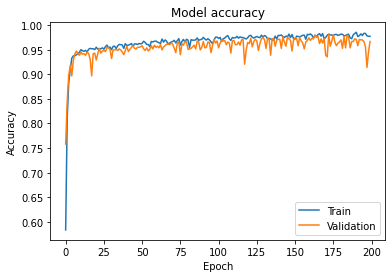

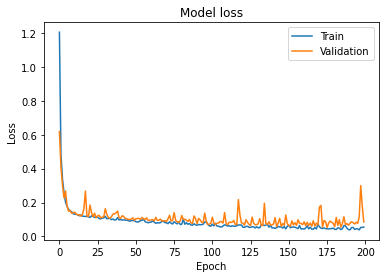

In [ ]:
#@title Supervised Label Propagation: Evaluate Convergence of Network Training 

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

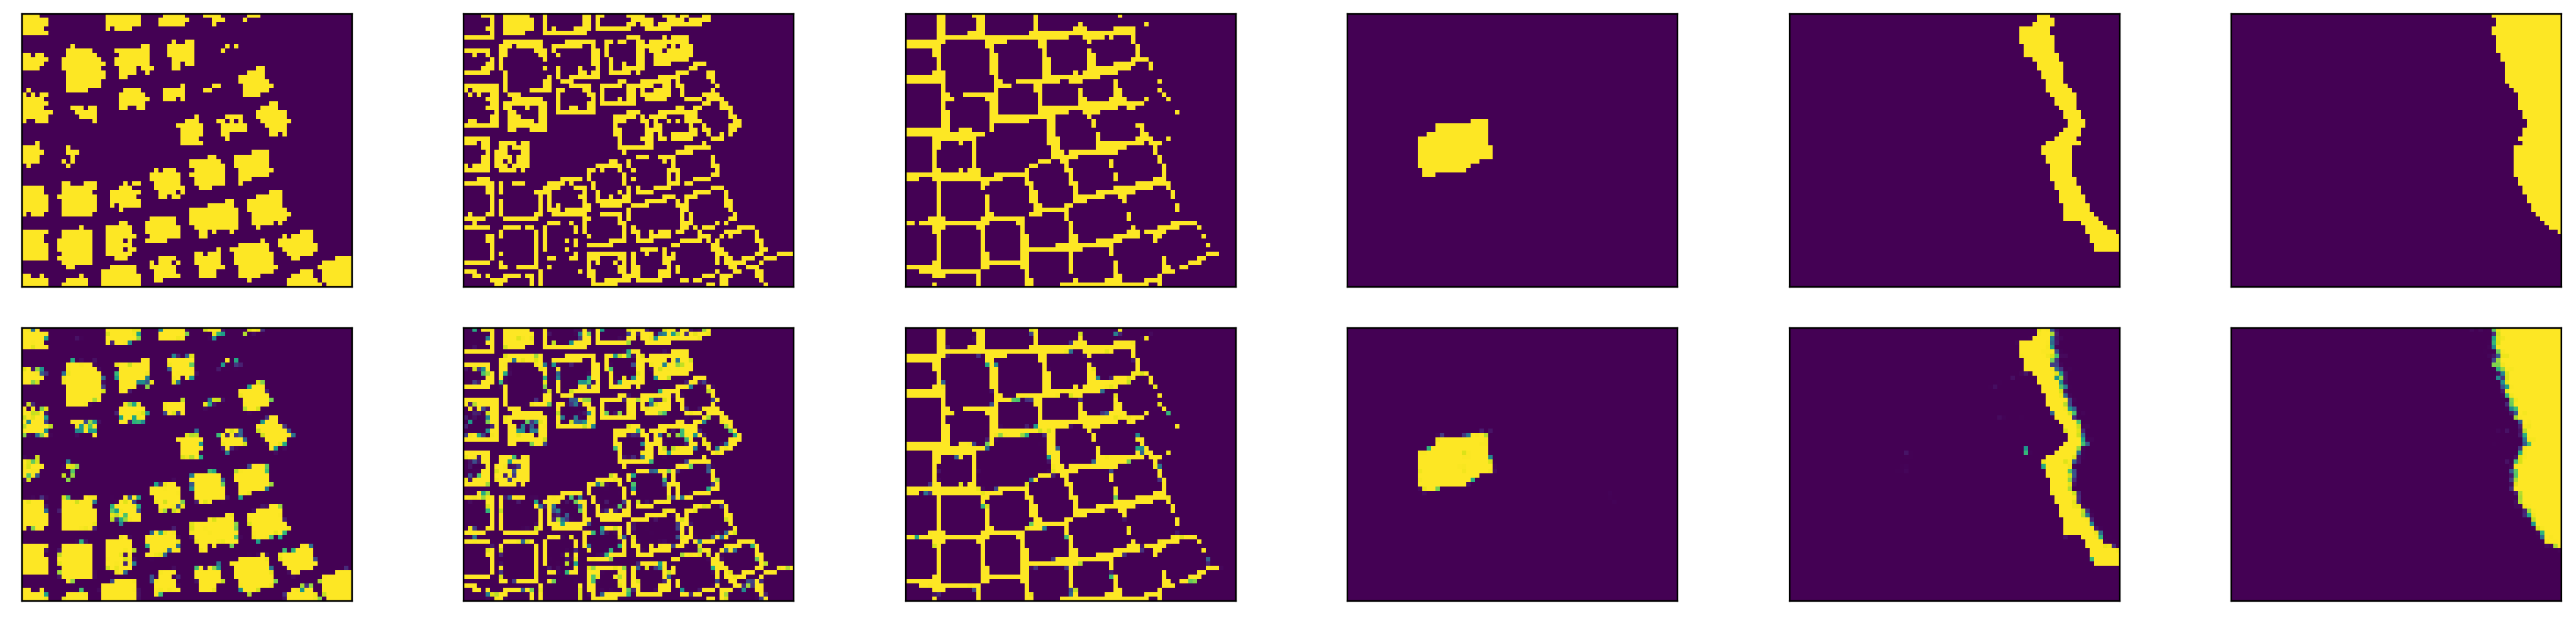

In [ ]:
#@title Supervised Label Propagation: Use Trained Network to Propagate Labels (Total)

labels_nn_flat = model.predict(Use_data)
labels_nn = labels_nn_flat.T.reshape(n_label,d1, d2)

f,a=plt.subplots(2,n_label,figsize=(n_label*3,4),dpi=200)
for i in range(n_label):
  a[0,i].imshow(Use_labels[i])
  a[1,i].imshow(labels_nn[i])

plt.setp(a,xticks=[],yticks=[])
plt.subplots_adjust(bottom=0,top=1,right=1,left=0,hspace=0.15,wspace=0.025)

(6, 62, 75)
(6, 62, 75)


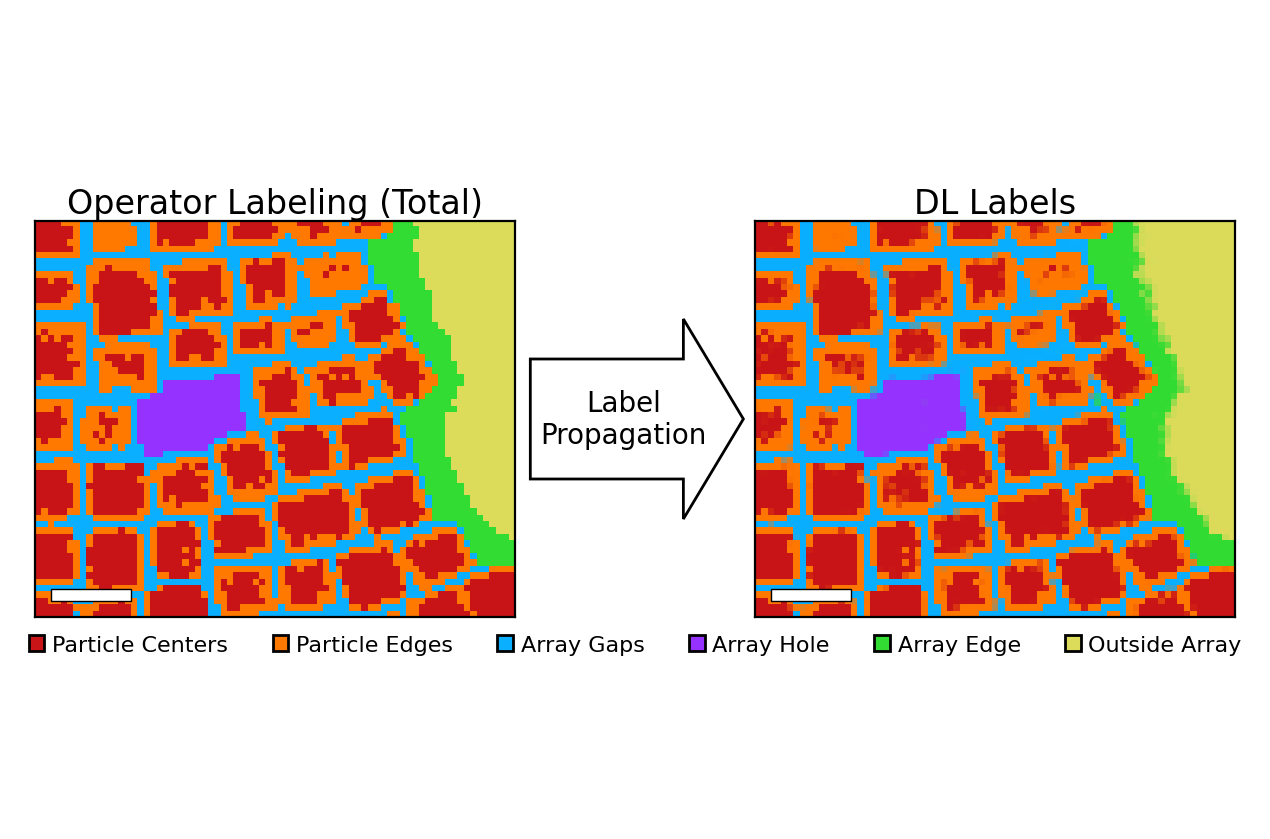

In [ ]:
#@title Supervised Label Propagation: Display Propagated Labels (Total)

f,a=plt.subplots(1,2,dpi=200)
a[0].imshow(MakeCompositeImage(Use_labels,comp_colors))
a[0].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[0].set_title('Operator Labeling (Total)',va='center')
a[1].imshow(MakeCompositeImage(labels_nn,comp_colors))
a[1].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[1].set_title('DL Labels',va='center')

ax=f.add_axes([0,0,1,1],xticks=[],yticks=[])
ax.set_axis_off()
ax.set_xlim(0,1);ax.set_ylim(0,1)
ax.arrow(0.4125,0.5,0.17755,0,width=0.15,head_width=0.25,head_length=0.05,fc='None',length_includes_head=True)
ax.text(0.49,0.5,'Label\nPropagation',ha='center',va='center')
ax.legend(comp_handles,comp_labels,loc='lower center',bbox_to_anchor=(0.5,0.18),
          frameon=False,ncol=n_label,handlelength=0.7,handletextpad=0.35,fontsize=8)
plt.setp(a,xticks=[],yticks=[])
plt.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.5)


In [ ]:
#@title Supervised Label Propagation: Prepare Dataset for Label Propagation (Partial Labeling)

#Select labels
Use_labels=labels_partial

#Remove all unlabeled pixels
n_label=len(Use_labels)
DL_data=[]
DL_labels=[]
Use_data = NMF_maps
Use_labels_reshaped = np.array(Use_labels).reshape((n_label,d1*d2)).T
for dat, labs in zip(Use_data,Use_labels_reshaped):
    if all(np.unique(labs) == np.array([0., 1.])):
        DL_labels.append(labs)
        DL_data.append(dat)
DL_data=np.asarray(DL_data);DL_labels=np.asarray(DL_labels)
DL_data.shape,DL_labels.shape

#Define Train/Test Data
dat_train,dat_test,lab_train,lab_test = train_test_split(DL_data, DL_labels, test_size=0.2, random_state=1)

In [ ]:
#@title Supervised Label Propagation: Create Network and Train on Labeled Data

model = Sequential()
model.add(Dense(30, activation='tanh', input_dim=dat_train.shape[1]))
model.add(Dense(30, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(30, activation='tanh',))

model.add(Dense(n_label, activation='softmax'))

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
#model.summary()
history = model.fit(
    dat_train, lab_train, validation_data=(dat_test, lab_test),
    epochs=200, batch_size=32, verbose=1, shuffle=True)

Epoch 1/200
17/17 [==============================] - 0s 11ms/step - loss: 1.6424 - accuracy: 0.4210 - val_loss: 1.5278 - val_accuracy: 0.4015
Epoch 2/200
17/17 [==============================] - 0s 3ms/step - loss: 1.3628 - accuracy: 0.4357 - val_loss: 1.3223 - val_accuracy: 0.4161
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 1.1173 - accuracy: 0.5717 - val_loss: 1.0349 - val_accuracy: 0.6277
Epoch 4/200
17/17 [==============================] - 0s 3ms/step - loss: 0.8335 - accuracy: 0.7555 - val_loss: 0.7623 - val_accuracy: 0.7810
Epoch 5/200
17/17 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.8603 - val_loss: 0.5781 - val_accuracy: 0.8540
Epoch 6/200
17/17 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.9301 - val_loss: 0.4364 - val_accuracy: 0.9197
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.9485 - val_loss: 0.3427 - val_accuracy: 0.9489
Epoch 8/200


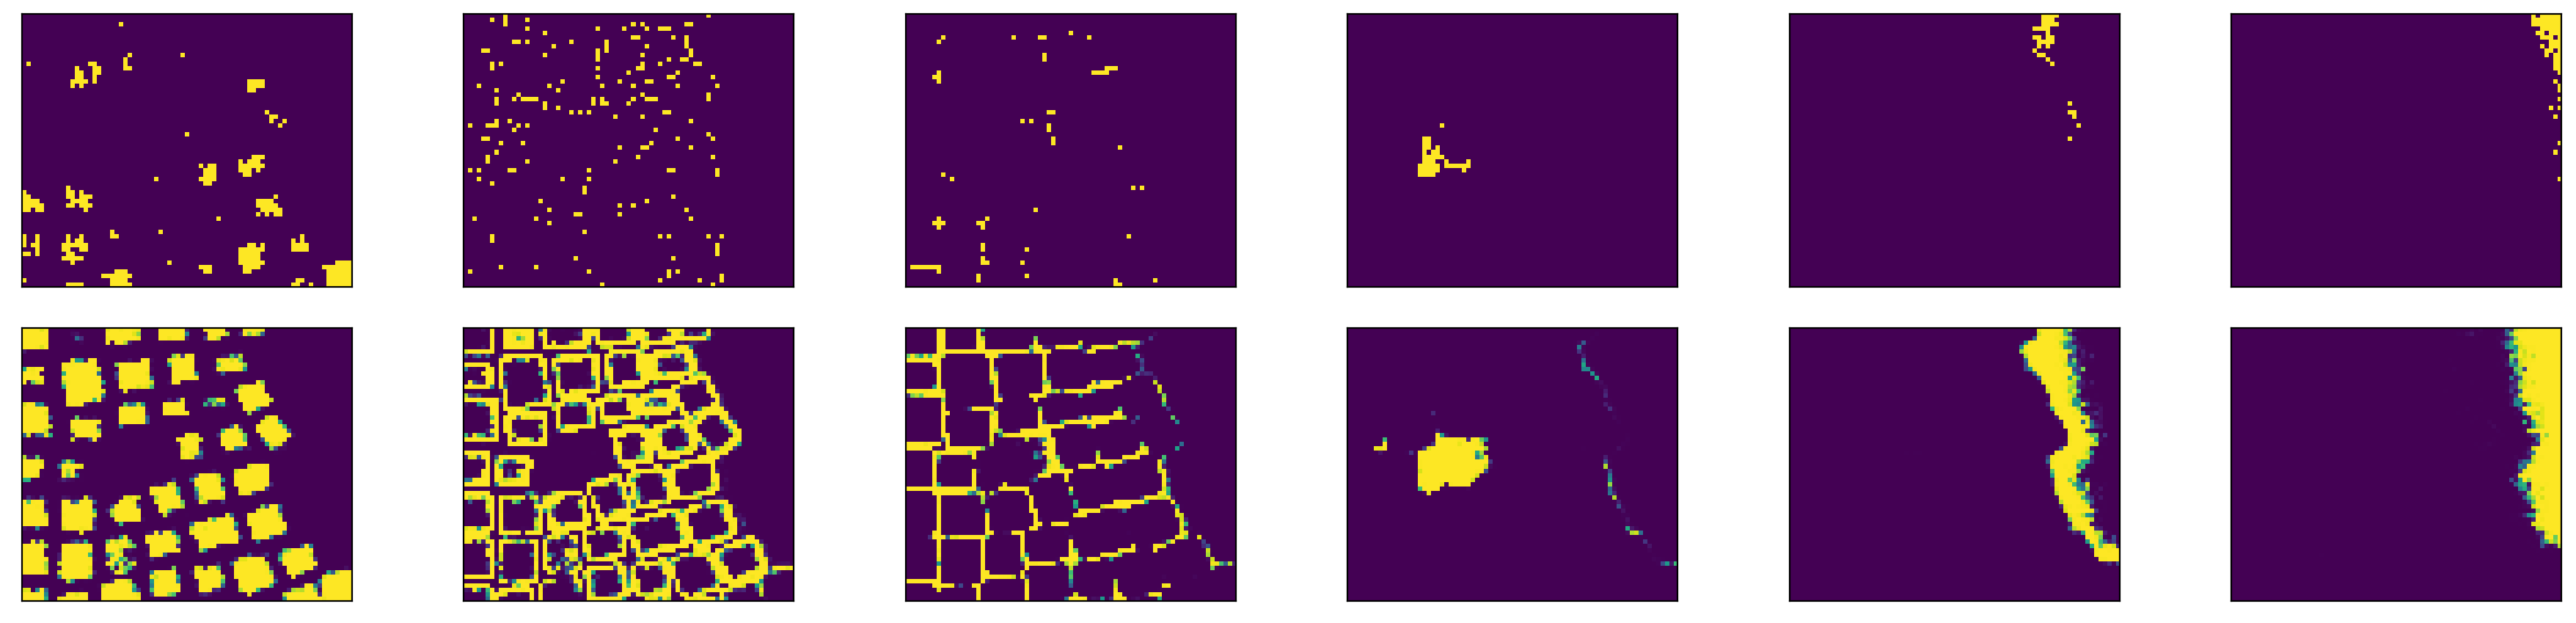

In [ ]:
#@title Supervised Label Propagation: Use Trained Network to Propagate Labels (Partial)

labels_nn_flat = model.predict(Use_data)
labels_nn = labels_nn_flat.T.reshape(n_label,d1, d2)

f,a=plt.subplots(2,n_label,figsize=(n_label*3,4),dpi=200)
for i in range(n_label):
  a[0,i].imshow(Use_labels[i])
  a[1,i].imshow(labels_nn[i])

plt.setp(a,xticks=[],yticks=[])
plt.subplots_adjust(bottom=0,top=1,right=1,left=0,hspace=0.15,wspace=0.025)

(6, 62, 75)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in true_divide


(6, 62, 75)


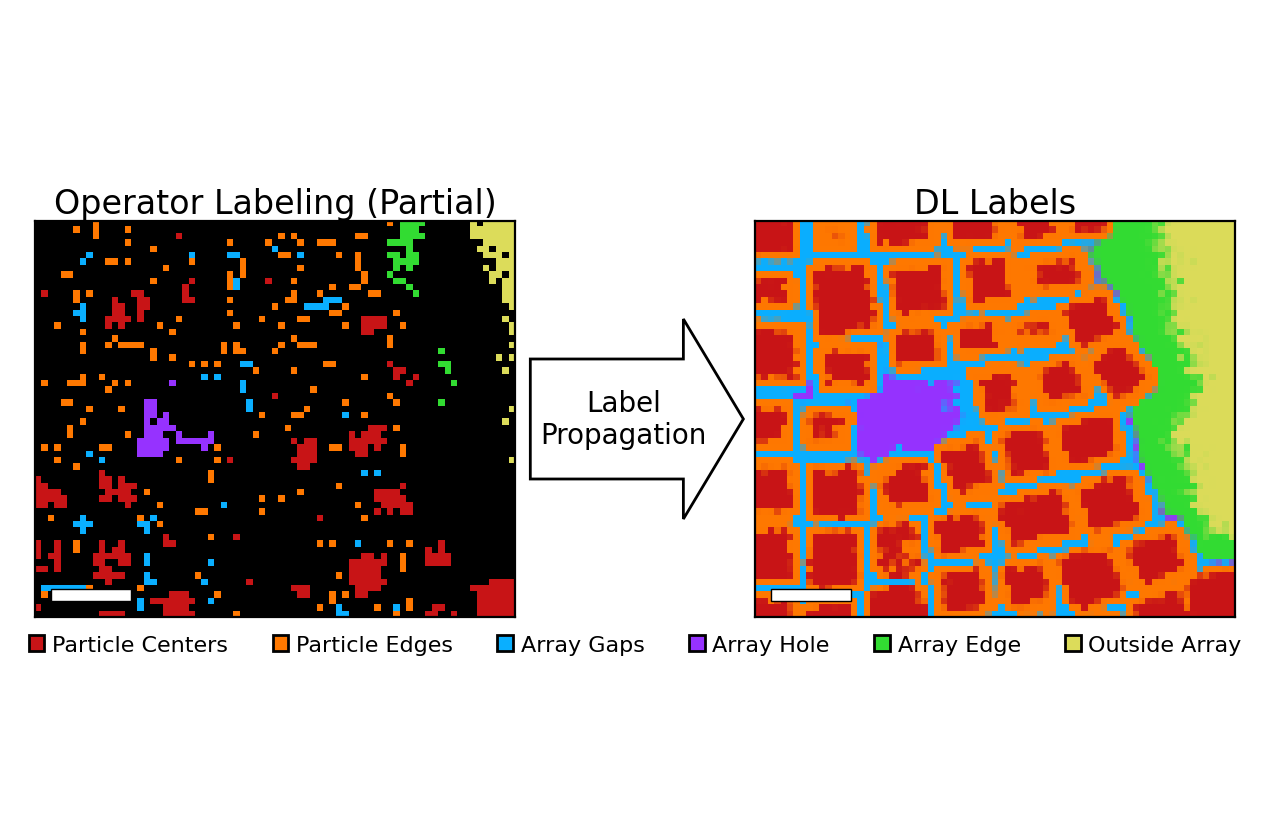

In [ ]:
#@title Supervised Label Propagation: Display Propagated Labels (Partial)

f,a=plt.subplots(1,2,dpi=200)
a[0].imshow(MakeCompositeImage(Use_labels,comp_colors))
a[0].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[0].set_title('Operator Labeling (Partial)',va='center')
a[1].imshow(MakeCompositeImage(labels_nn,comp_colors))
a[1].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[1].set_title('DL Labels',va='center')

ax=f.add_axes([0,0,1,1],xticks=[],yticks=[])
ax.set_axis_off()
ax.set_xlim(0,1);ax.set_ylim(0,1)
ax.arrow(0.4125,0.5,0.17755,0,width=0.15,head_width=0.25,head_length=0.05,fc='None',length_includes_head=True)
ax.text(0.49,0.5,'Label\nPropagation',ha='center',va='center')
ax.legend(comp_handles,comp_labels,loc='lower center',bbox_to_anchor=(0.5,0.18),
          frameon=False,ncol=n_label,handlelength=0.7,handletextpad=0.35,fontsize=8)
plt.setp(a,xticks=[],yticks=[])
plt.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.5)


(2, 62, 75)
(2, 62, 75)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in true_divide


(4, 62, 75)
(4, 62, 75)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in true_divide


(6, 62, 75)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in true_divide


(6, 62, 75)


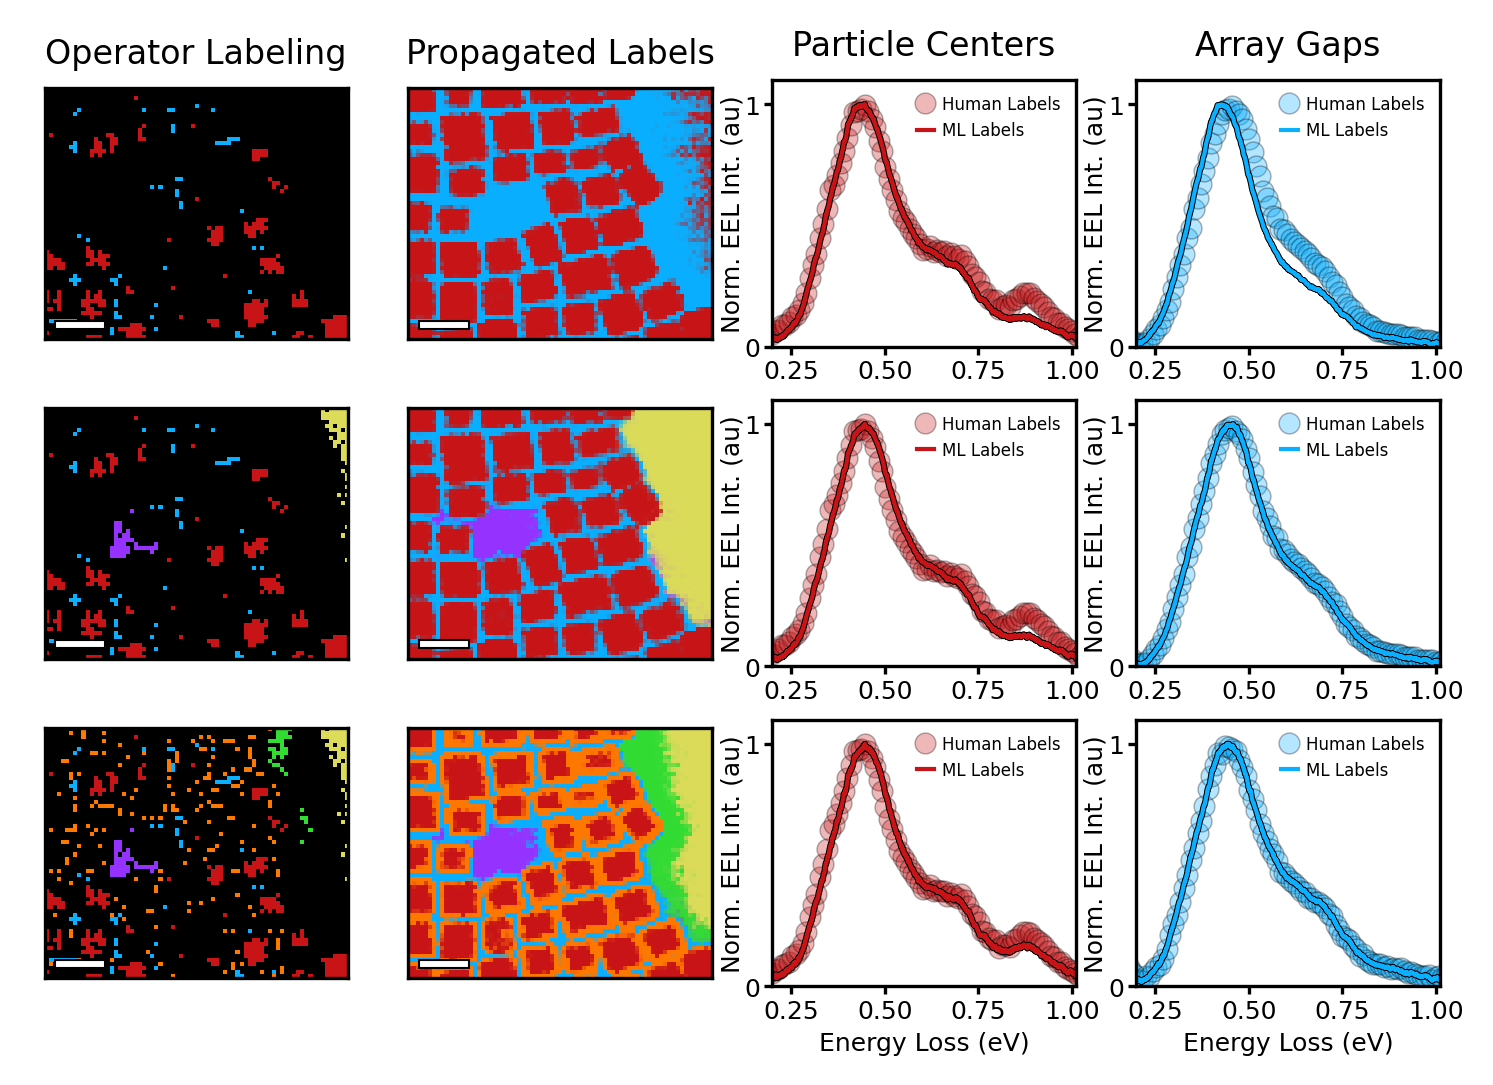

In [ ]:
#@title Supervised Label Propagation: Compare Different Numbers of Labels (Partial Labeling)

#Select labels
plabels=[[pmask_particle_centers,pmask_array_gaps],
        [pmask_particle_centers,pmask_array_gaps,pmask_array_hole,pmask_outside],
        labels_partial]


#Perform NN training for all 3 label values
nnlabels,pspecs,nnspecs=[[],[],[]],[[],[],[]],[[],[],[]]
Use_data=NMF_maps
for i in range(3):
  n_label=len(plabels[i])
  DL_data=[];DL_labels=[]
  lab_reshaped = np.array(plabels[i]).reshape((n_label,d1*d2)).T
  for dat, labs in zip(Use_data,lab_reshaped):
    if all(np.unique(labs) == np.array([0., 1.])): DL_labels.append(labs); DL_data.append(dat)
  DL_data=np.asarray(DL_data);DL_labels=np.asarray(DL_labels)
  DL_data.shape,DL_labels.shape
  dat_train,dat_test,lab_train,lab_test = train_test_split(DL_data, DL_labels, test_size=0.2, random_state=1)
  model = Sequential()
  model.add(Dense(30, activation='tanh', input_dim=dat_train.shape[1]))
  model.add(Dense(30, activation='tanh'));model.add(Dense(30, activation='tanh'));model.add(Dense(30, activation='tanh'))
  model.add(Dense(n_label, activation='softmax'))
  model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
  history = model.fit(dat_train,lab_train,validation_data=(dat_test, lab_test),epochs=100, batch_size=32, verbose=0, shuffle=True)
  labels_nn_flat = model.predict(Use_data)
  nnlabels[i] = labels_nn_flat.T.reshape(n_label,d1, d2)
  nnspecs[i] = GetComponentSpectrum(NMFdat,nnlabels[i])
  pspecs[i] = GetComponentSpectrum(NMFdat,plabels[i])

comp_colors_3=[[Red,Blue],[Red,Blue,Purple,Yellow],comp_colors]
comp_labels_3=[[comp_labels[0],comp_labels[2]],[comp_labels[0],comp_labels[2],comp_labels[3],comp_labels[5]],comp_labels]

f,a=plt.subplots(3,4,dpi=300)
for i in range(3):
  a[i,0].imshow(MakeCompositeImage(plabels[i],comp_colors_3[i]))
  a[i,0].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
  a[i,1].imshow(MakeCompositeImage(nnlabels[i],comp_colors_3[i]))
  a[i,1].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
  a[i,2].plot(E,NormArray(pspecs[i][0]),lw=0,mew=0.35,mec='k',mfc=Red,marker='o',alpha=0.3,markersize=5,markevery=30,label='Human Labels')
  a[i,2].plot(E,NormArray(nnspecs[i][0]),color='k',lw=1.5)
  a[i,2].plot(E,NormArray(nnspecs[i][0]),color=Red,lw=1,label='ML Labels')
  a[i,3].plot(E,NormArray(pspecs[i][1]),lw=0,mew=0.35,mec='k',mfc=Blue,marker='o',alpha=0.3,markersize=5,markevery=30,label='Human Labels')
  a[i,3].plot(E,NormArray(nnspecs[i][1]),color='k',lw=1.5)
  a[i,3].plot(E,NormArray(nnspecs[i][1]),color=Blue,lw=1,label='ML Labels')
  a[i,2].tick_params(labelsize=6,length=2,pad=1);a[i,3].tick_params(labelsize=6,length=2,pad=1)
  a[i,2].set_ylabel('Norm. EEL Int. (au)',fontsize=6,labelpad=0);a[i,3].set_ylabel('Norm. EEL Int. (au)',fontsize=6,labelpad=0)
  a[i,2].legend(frameon=False,fontsize=4,handlelength=1,handletextpad=0.5)
  a[i,3].legend(frameon=False,fontsize=4,handlelength=1,handletextpad=0.5)
a[0,0].set_title('Operator Labeling',fontsize=8)
a[0,1].set_title('Propagated Labels',fontsize=8)
a[0,2].set_title('Particle Centers',fontsize=8)
a[0,3].set_title('Array Gaps',fontsize=8)
a[2,2].set_xlabel('Energy Loss (eV)',fontsize=6,labelpad=2);
a[2,3].set_xlabel('Energy Loss (eV)',fontsize=6,labelpad=2)
p=plt.setp(a[:,:2],xticks=[],yticks=[])
p=plt.setp(a[:,2:],xlim=(0.2,1.01),ylim=(0,1.1),yticks=[0,1])

In [ ]:
NMF_spectra.shape,NMFdat_flat.shape

((24, 3000), (4650, 3000))

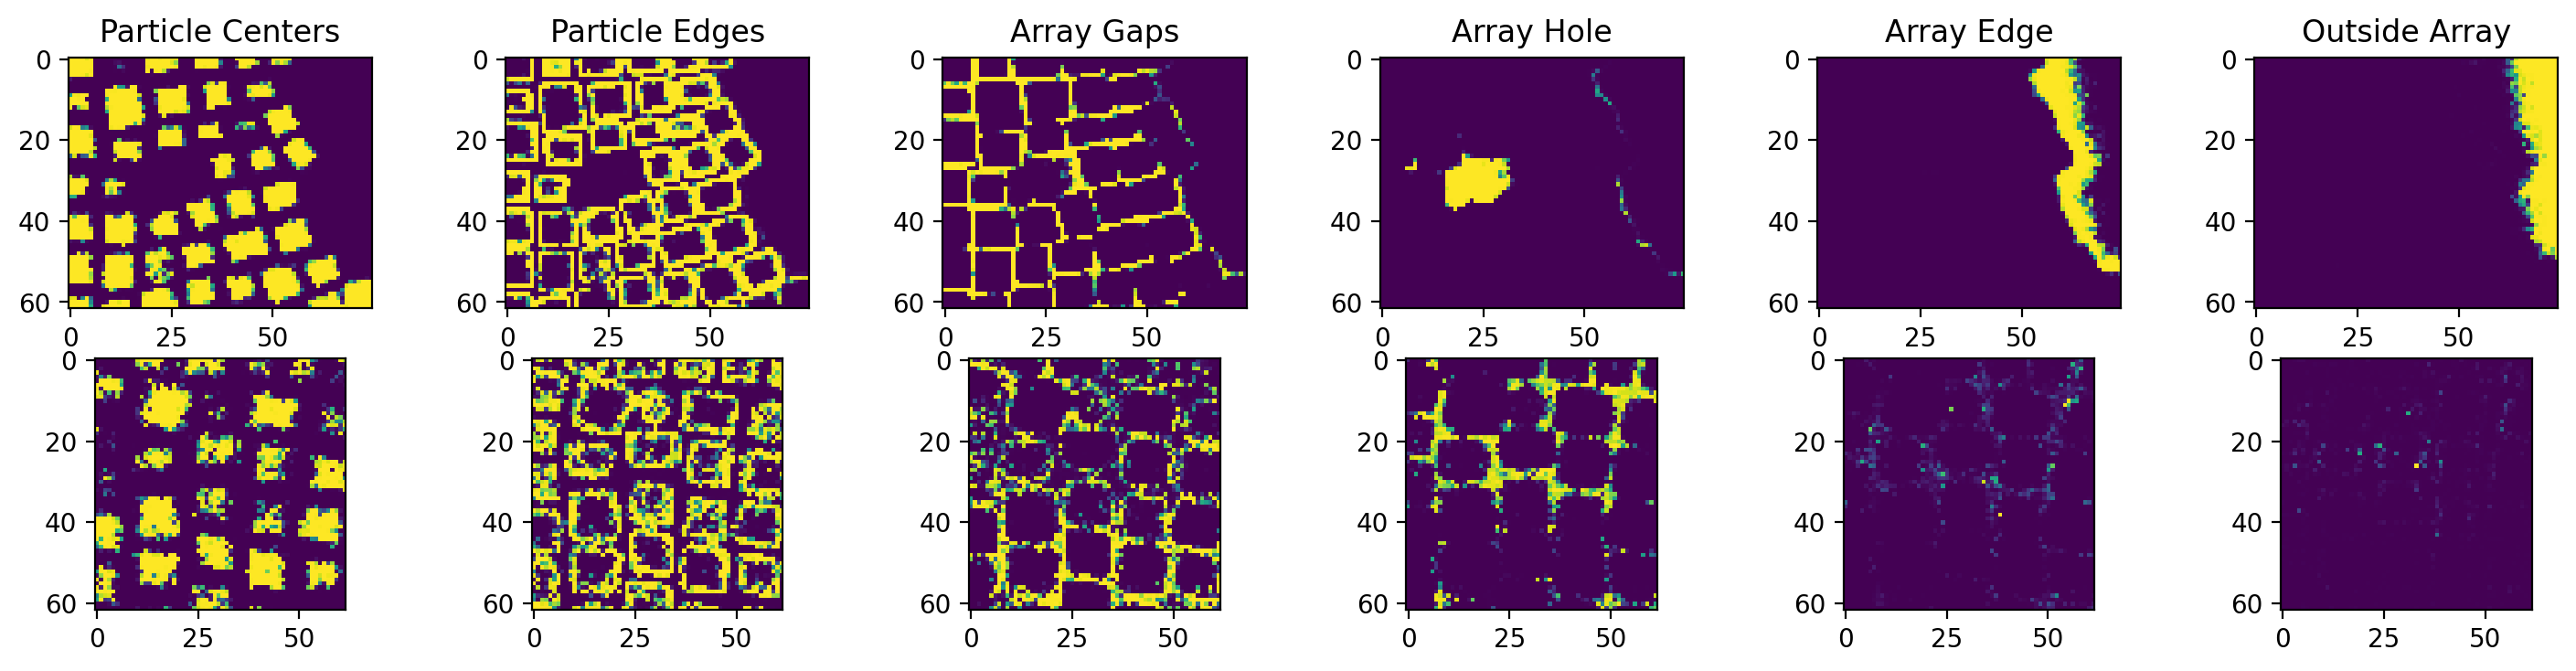

In [ ]:
#@title Supervised Label Propagation: Transferability of Network

#Select Dataset for Application of Trained Network
New_SI=SI2f
New_cal=SI2_imcal
New_scale=20

#Number of NMF Components should stay the same 

#Run decomposition on new dataset
newNMFdat = np.copy(New_SI)
newNMFdat=(newNMFdat-np.amin(newNMFdat))/np.ptp(newNMFdat)
nd1, nd2, nd3 = newNMFdat.shape
newNMFdat_flat = newNMFdat.reshape(nd1*nd2, nd3)
clf = NMF(n_components=n_comp, random_state=42)
newNMF_maps = clf.fit_transform(newNMFdat_flat)
newNMF_spectra = clf.components_

#Apply trained network to new dataset
New_data = np.zeros((nd1*nd2,n_comp))
for i in range(nd1*nd2):
  lr=LinearRegression()
  lr.fit(NMF_spectra.T, newNMFdat_flat[i])
  New_data[i] = lr.coef_
labels_nnt_flat = model.predict(New_data)
labels_nnt = labels_nnt_flat.T.reshape(n_label,nd1, nd2)

f,a=plt.subplots(2,n_label,figsize=(n_label*3,4),dpi=200)
for i in range(n_label):
  a[0,i].imshow(labels_nn[i])
  a[0,i].set_title(comp_labels[i])
  a[1,i].imshow(labels_nnt[i])

(6, 62, 75)
(6, 62, 62)


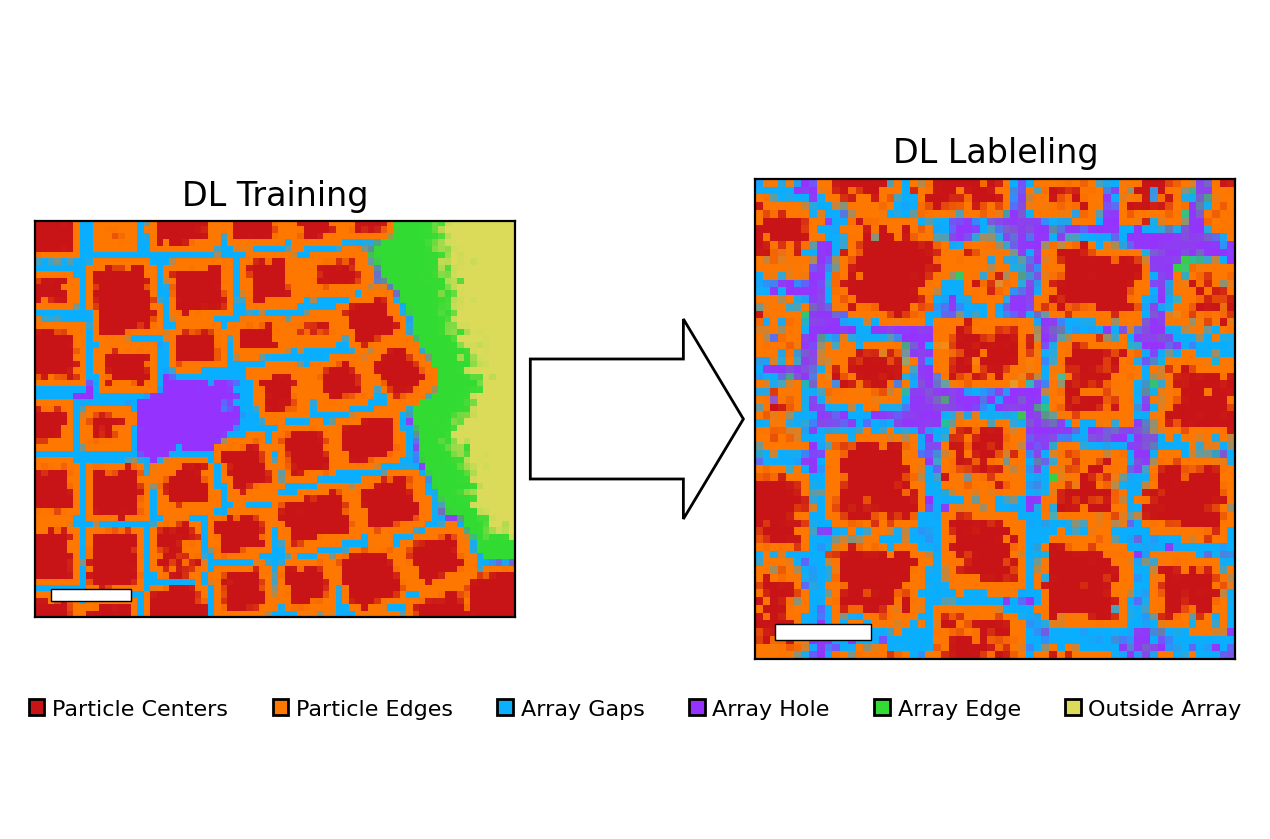

In [ ]:
#@title Supervised Label Propagation: Display DL Labels (Trained on different dataset)

f,a=plt.subplots(1,2,dpi=200)
a[0].imshow(MakeCompositeImage(labels_nn,comp_colors))
a[0].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[0].set_title('DL Training',va='center',y=1.02)
a[1].imshow(MakeCompositeImage(labels_nnt,comp_colors))
a[1].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[1].set_title('DL Lableling',va='center',y=1.02)

ax=f.add_axes([0,0,1,1],xticks=[],yticks=[])
ax.set_axis_off()
ax.set_xlim(0,1);ax.set_ylim(0,1)
ax.arrow(0.4125,0.5,0.17755,0,width=0.15,head_width=0.25,head_length=0.05,fc='None',length_includes_head=True)
ax.legend(comp_handles,comp_labels,loc='lower center',bbox_to_anchor=(0.5,0.1),
          frameon=False,ncol=n_label,handlelength=0.7,handletextpad=0.35,fontsize=8)
plt.setp(a,xticks=[],yticks=[])
plt.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.5)


In [ ]:
#@title Unsupervised Labeling: Set Up and Train Autoencoder

#Set number of spectral channels
#Note: Autoencoder can only handle certain values it is often necessary
#      to cut off a few channels off the end of the spectrum to get the 
#      encoder to run. If your spectrum has 3000 channels and you get an 
#      error that says "Dimensions must be equal, but are 3008 and 3000..."
#      reduce use_d3 until this error disappears. Try to get as close to
#      d3 as possible to retain the majority of the spectral information.
use_d3=d3-24

#Set Autoencoder Parameters
latent_dim = 2; batch_size = 32; kernel_size = 3

#Set number of iterations for Autoencoder training
n_epoch=25

#Set up Encoder
Data_train = np.reshape(NMFdat_flat[:,:use_d3], [-1, use_d3, 1]).astype('float32')
layer_filters = [8, 16, 32, 64, 64]
inputs = Input(shape=(use_d3, 1), name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv1D(filters=filters,kernel_size=kernel_size,activation='relu',
               strides=2,padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs,latent,name='encoder')
#encoder.summary()

#Set up Decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2])(latent_inputs)
x = Reshape((shape[1], shape[2]))(x)
lrelu = lambda x: LeakyReLU(alpha=0.1)(x)
for filters in layer_filters[::-1]:
    x = Conv1D(filters=filters,kernel_size=3,activation=lrelu,strides=1,padding='same',
               kernel_initializer=tf.initializers.glorot_uniform(seed=1))(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=1, activation=lrelu, strides=1, padding='same',
           kernel_initializer=tf.initializers.glorot_uniform(seed=1))(x)
x = BatchNormalization()(x)
outputs = Conv1D(filters=1,kernel_size=kernel_size,activation='linear',padding='same',name='decoder_output',
                 kernel_initializer=tf.initializers.glorot_uniform(seed=1))(x)
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()

#Set up Autoencoder
autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoencoder')
#autoencoder.summary()

#Train Autoencoder
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(Data_train,Data_train,epochs=n_epoch,batch_size=batch_size)

Epoch 1/25
146/146 [==============================] - 30s 206ms/step - loss: 0.1566
Epoch 2/25
146/146 [==============================] - 31s 211ms/step - loss: 0.0030
Epoch 3/25
146/146 [==============================] - 30s 208ms/step - loss: 0.0017
Epoch 4/25
146/146 [==============================] - 31s 210ms/step - loss: 0.0012
Epoch 5/25
146/146 [==============================] - 30s 204ms/step - loss: 9.3949e-04
Epoch 6/25
146/146 [==============================] - 30s 203ms/step - loss: 7.7971e-04
Epoch 7/25
146/146 [==============================] - 31s 210ms/step - loss: 7.3814e-04
Epoch 8/25
146/146 [==============================] - 30s 207ms/step - loss: 7.1563e-04
Epoch 9/25
146/146 [==============================] - 30s 205ms/step - loss: 6.6277e-04
Epoch 10/25
146/146 [==============================] - 31s 209ms/step - loss: 6.5005e-04
Epoch 11/25
146/146 [==============================] - 31s 209ms/step - loss: 6.1990e-04
Epoch 12/25
146/146 [=========================

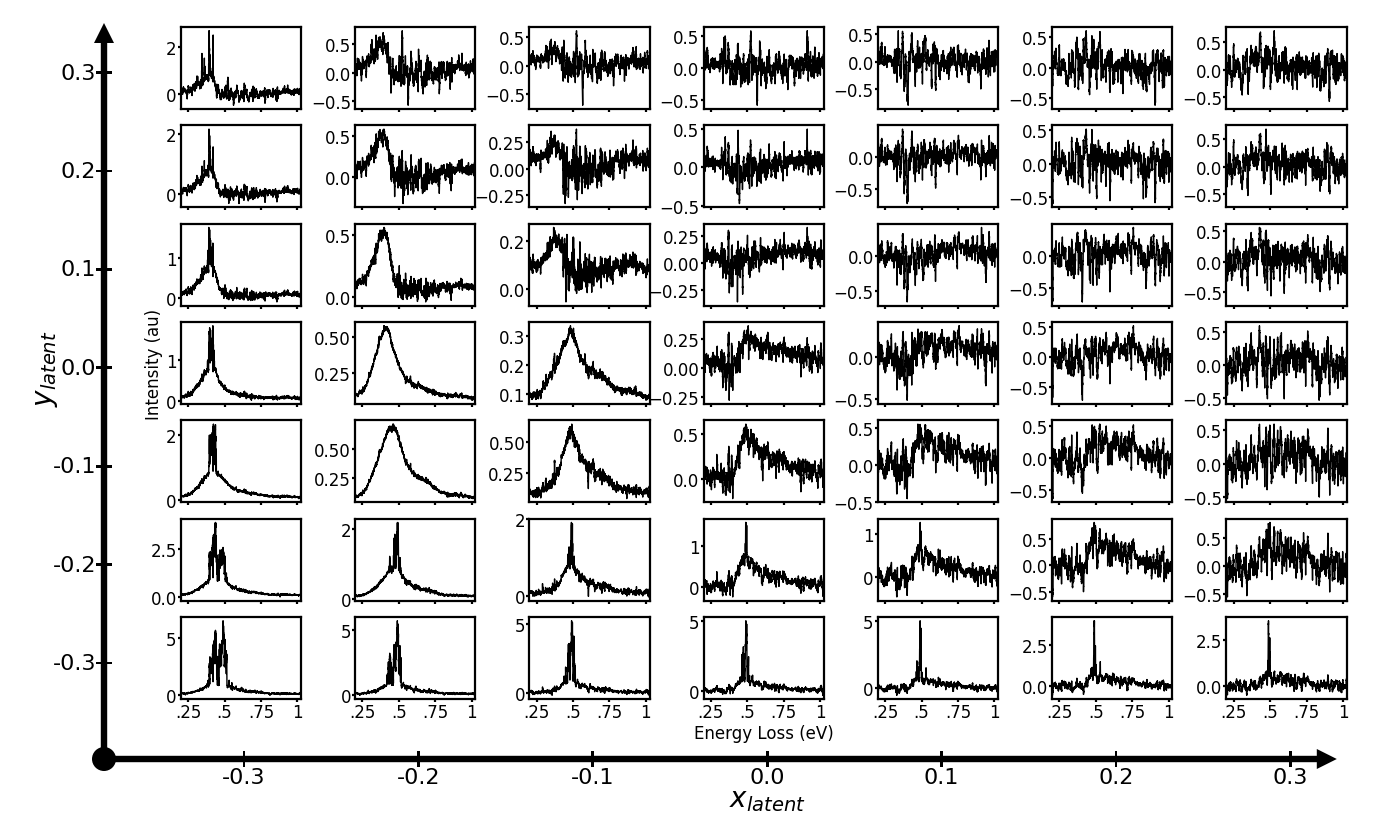

In [ ]:
#@title Unsupervised Labeling: Visualize Latent Space

#Visualize Latent Space
N_latent=7
xm,xM = -0.3,0.3; ym,yM=-0.3,0.3

grid_x=np.linspace(xm,xM,N_latent)
grid_y=np.linspace(ym,yM,N_latent)[::-1]
latentspace=np.zeros((N_latent,N_latent,use_d3))

fig = plt.figure(figsize = (6.7,4),dpi=200) 
ax_latent=fig.add_axes([0,0,1,1],xticks=[],yticks=[])
ax_latent.axis('off')
for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    lat_coord = np.array([[xi, yi]])
    lat_spec=decoder.predict(lat_coord)[0,:,0]
    ax=fig.add_subplot(N_latent,N_latent,(i*N_latent)+j+1)
    ax.plot(E[:use_d3],lat_spec,color='k',lw=0.5)
    ax.tick_params(labelsize=6,length=1,pad=0.5)
    ax.set_xlim(0.2,1.025)
    ax.set_xticks([0.25,0.5,0.75,1.0])
    if i<N_latent-1: ax.set_xticklabels([])
    if i==N_latent-1: 
      ax.set_xticklabels(['.25','.5','.75','1'])
      if j==int((N_latent-1)/2.): ax.set_xlabel('Energy Loss (eV)',fontsize=6,labelpad=1)
    if j==0 and i==int((N_latent-1)/2.): ax.set_ylabel('Intensity (au)',fontsize=6,labelpad=1)
ax_latent.arrow(0.105,0.075,0.92*6.7/4,0,ec='None',fc='k',width=0.008,head_length=0.025,head_width=0.025,length_includes_head=True)
ax_latent.arrow(0.105,0.075,0,0.92,ec='None',fc='k',width=0.008,head_length=0.025,head_width=0.025,length_includes_head=True)
ax_latent.add_patch(Circle((0.105,0.075),0.015,fc='k',ec='None'))
ax_latent.set_xlim(0,1*6.7/4.);ax_latent.set_ylim(0,1)
for i in range(N_latent):
  ax_latent.arrow(0.28+0.218*i,0.065,0,0.02,head_length=0,head_width=0,width=0.0035,fc='k',ec='None')
  ax_latent.text(0.28+0.218*i,0.065,str(round(0.1*(-3+i),1)),fontsize=8,ha='center',va='top',color='k')
  if i==int((N_latent-1)/2.): ax_latent.text(0.28+0.218*i,0.0425,r'$x_{latent}$',fontsize=10,ha='center',va='top',color='k')
for i in range(N_latent):
  ax_latent.arrow(0.095,0.195+0.123*i,0.02,0,head_length=0,head_width=0,width=0.0035,fc='k',ec='None')
  ax_latent.text(0.095,0.195+0.123*i,str(round(0.1*(-3+i),1)),fontsize=8,ha='right',va='center',color='k')
  if i==int((N_latent-1)/2.): ax_latent.text(0.05,0.195+0.123*i,r'$y_{latent}$',fontsize=10,ha='right',va='center',color='k',rotation=90)
plt.subplots_adjust(bottom=0.15,left=0.12,right=0.99,top=0.99,hspace=0.2,wspace=0.45)

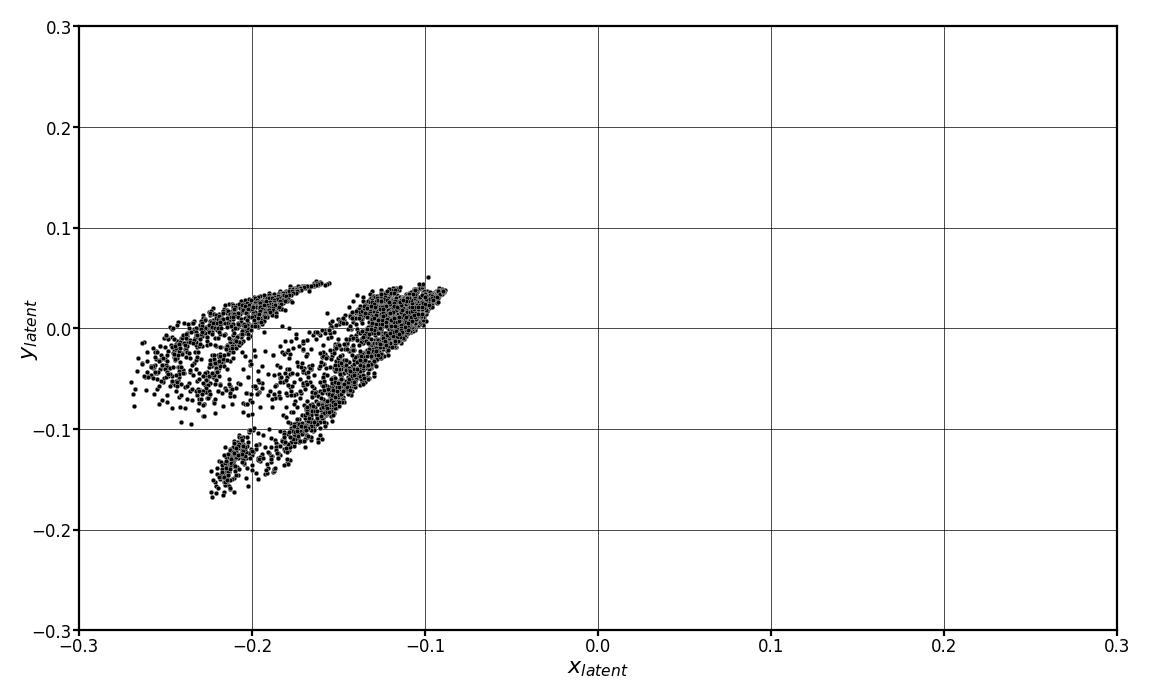

In [ ]:
#@title Unsupervised Labeling: Visualize Dataset in Latent Space

Dataset_AE = encoder.predict(Data_train)
fig=plt.figure(figsize=(6.7,4),dpi=200)
ax=fig.add_subplot(111)
ax.scatter(Dataset_AE[:,0],Dataset_AE[:,1],ec='w',fc='k',s=3,lw=0.125,zorder=20)
ax.set_xlim(xm,xM);ax.set_ylim(ym,yM)
ax.tick_params(labelsize=6,length=2,pad=0.5)
ax.set_xlabel(r'$x_{latent}$',fontsize=8,labelpad=1)
ax.set_ylabel(r'$y_{latent}$',fontsize=8,labelpad=-3)
ax.grid(zorder=0,lw=0.25,color='k')

(2, 62, 75)


[]

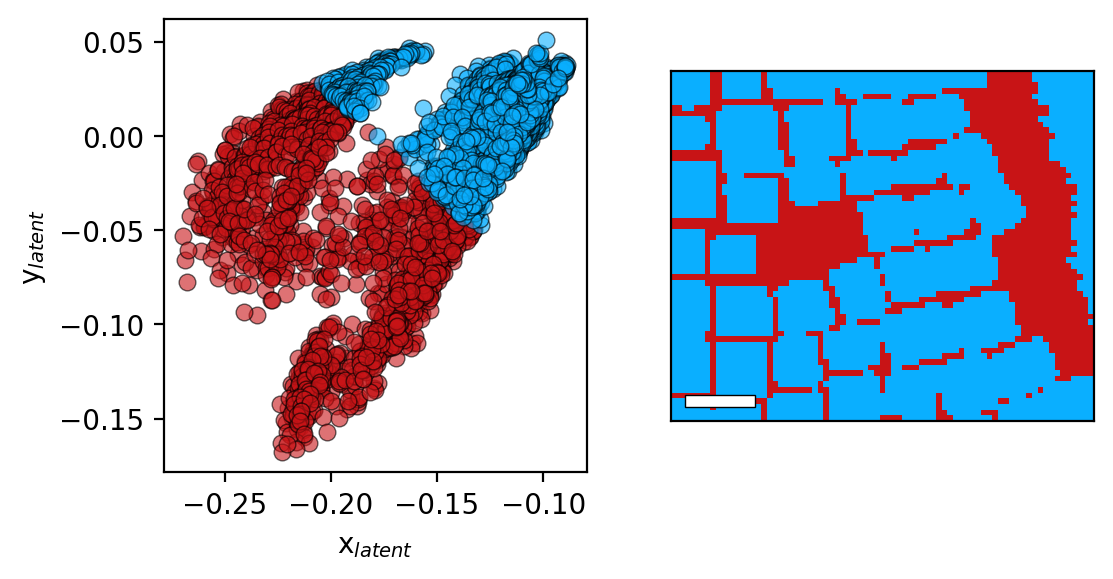

In [ ]:
#@title Unsupervised Labeling: Use Distance Metrics to Label Dataset (K-Means)

#Set # of Labels
n_kmeans=2
comp_colors_kmeans=[Red,Blue,Purple,Yellow,Orange,Green]

#Perform K-Means Clustering
k_means = MiniBatchKMeans(n_clusters=n_kmeans)
k_means.fit(Dataset_AE)
labels_kmeans = k_means.labels_

labels_ae_latent=[]
labels_ae=[]
for i in range(n_kmeans): 
  labels_ae_latent.append(Dataset_AE[np.where(labels_kmeans==i)])
  labels_ae.append((labels_kmeans==i).reshape(d1,d2))

f,a=plt.subplots(1,2,figsize=(6,3),dpi=200)
for i in range(n_kmeans):
  a[0].scatter(labels_ae_latent[i][:,0],labels_ae_latent[i][:,1],
               fc=comp_colors_kmeans[i],ec='k',alpha=0.6,lw=0.5)
  a[0].set_xlabel(r'x$_{latent}$');a[0].set_ylabel(r'y$_{latent}$')
a[1].imshow(MakeCompositeImage(labels_ae,comp_colors_kmeans))
a[1].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[1].set_xticks([]);a[1].set_yticks([])


(2, 62, 75)


[]

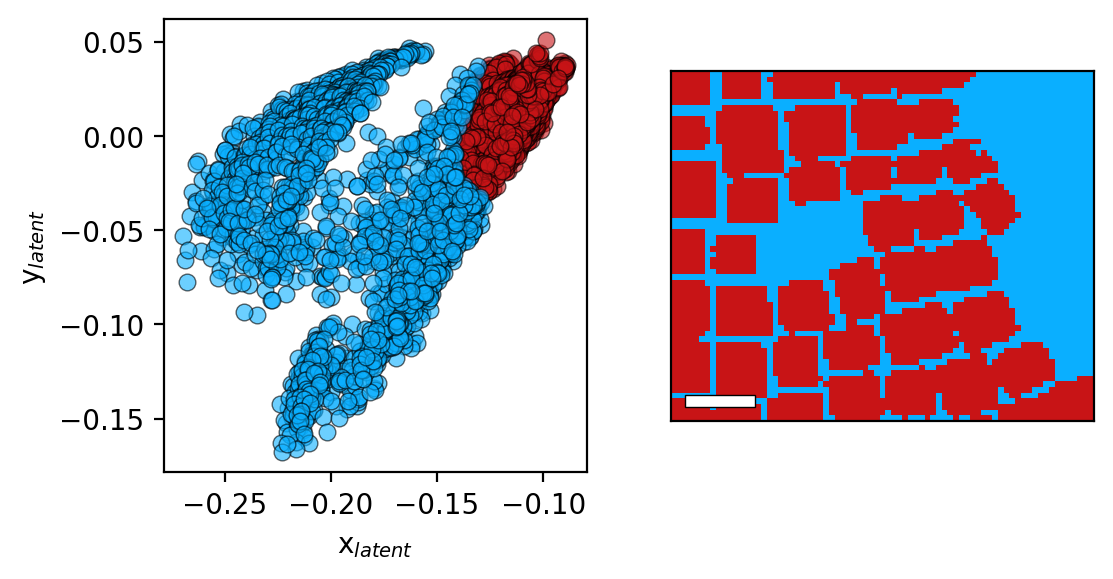

In [ ]:
#@title Unsupervised Labeling: Use Distance Metrics to Label Dataset (GMM)

#Set # of Labels
n_gmm=2
comp_colors_gmm=[Red,Blue,Purple,Yellow,Orange,Green]

#Perform K-Means Clustering
gmm = GaussianMixture(n_components=n_gmm)
labels_gmm = gmm.fit_predict(Dataset_AE)

labels_ae_latent=[]
labels_ae=[]
for i in range(n_gmm): 
  labels_ae_latent.append(Dataset_AE[np.where(labels_gmm==i)])
  labels_ae.append((labels_gmm==i).reshape(d1,d2))

f,a=plt.subplots(1,2,figsize=(6,3),dpi=200)
for i in range(n_gmm):
  a[0].scatter(labels_ae_latent[i][:,0],labels_ae_latent[i][:,1],
               fc=comp_colors_gmm[i],ec='k',alpha=0.6,lw=0.5)
  a[0].set_xlabel(r'x$_{latent}$');a[0].set_ylabel(r'y$_{latent}$')
a[1].imshow(MakeCompositeImage(labels_ae,comp_colors_gmm))
a[1].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
a[1].set_xticks([]);a[1].set_yticks([])


(2, 62, 75)
(2, 62, 75)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in true_divide


(2, 62, 75)
(4, 62, 75)
(4, 62, 75)
(4, 62, 75)
(6, 62, 75)
(6, 62, 75)
(6, 62, 75)


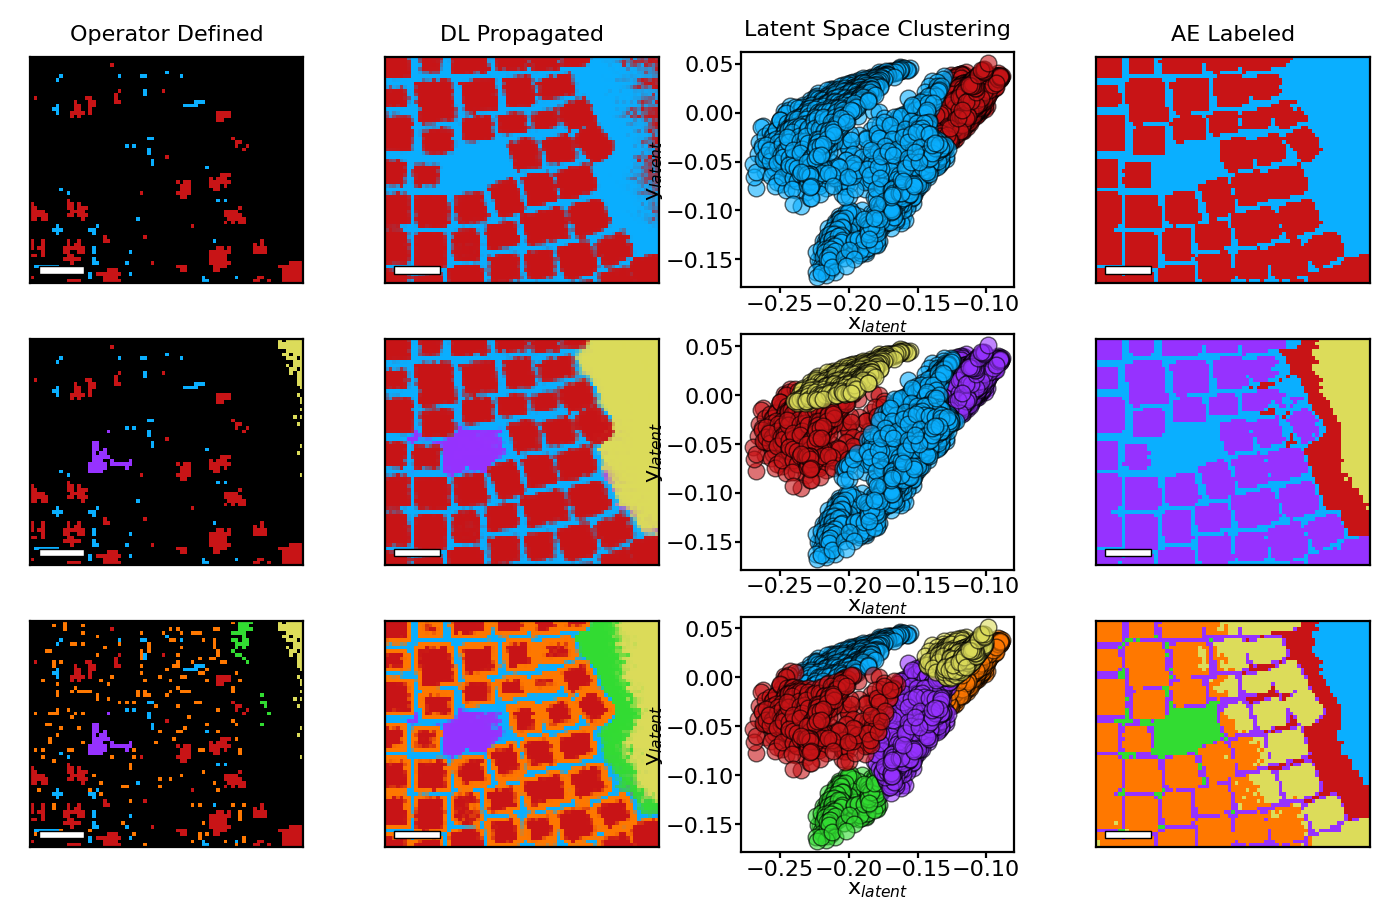

In [ ]:
#@title Unsupervised Labeling: Compare Supervised and Unsupervised Labeling

n_gmm_3=[2,4,6]
comp_colors_gmm_3=[[Red,Blue],[Purple,Red,Yellow,Blue],[Orange,Green,Blue,Purple,Red,Yellow]]

labels_ae_3,labels_ae_latent_3=[[],[],[]],[[],[],[]]
for i in range(3):
  labels_gmm=GaussianMixture(n_components=n_gmm_3[i]).fit_predict(Dataset_AE)
  for j in range(n_gmm_3[i]): 
    labels_ae_latent_3[i].append(Dataset_AE[np.where(labels_gmm==j)])
    labels_ae_3[i].append((labels_gmm==j).reshape(d1,d2))

f,a=plt.subplots(3,4,dpi=200,figsize=(6.7,4))
for i in range(3):
  a[i,0].imshow(MakeCompositeImage(plabels[i],comp_colors_3[i]))
  a[i,0].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
  a[i,1].imshow(MakeCompositeImage(nnlabels[i],comp_colors_3[i]))
  a[i,1].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
  for j in range(n_gmm_3[i]):
    a[i,2].scatter(labels_ae_latent_3[i][j][:,0],labels_ae_latent_3[i][j][:,1],
               fc=comp_colors_gmm_3[i][j],ec='k',alpha=0.6,lw=0.5)
  a[i,2].set_xlabel(r'x$_{latent}$',labelpad=0,fontsize=8)
  a[i,2].set_ylabel(r'y$_{latent}$',labelpad=0,fontsize=8)
  a[i,2].tick_params(labelsize=8,length=2,pad=0.5)
  xlims=a[i,2].get_xlim();ylims=a[i,2].get_ylim()
  a[i,3].imshow(MakeCompositeImage(labels_ae_3[i],comp_colors_gmm_3[i]))
  a[i,3].add_patch(Rectangle((2,d1-5),20/Use_cal,2,fc='w',ec='k',lw=0.5))
  a[i,0].set_xticks([]);a[i,1].set_xticks([]);a[i,3].set_xticks([])
  a[i,0].set_yticks([]);a[i,1].set_yticks([]);a[i,3].set_yticks([])
a[0,0].set_title('Operator Defined',fontsize=8)
a[0,1].set_title('DL Propagated',fontsize=8)
a[0,2].set_title('Latent Space Clustering',fontsize=8)
a[0,3].set_title('AE Labeled',fontsize=8)

plt.subplots_adjust(left=0,right=1,wspace=0.3,top=1,bottom=0)


(6, 62, 75)
(6, 62, 75)


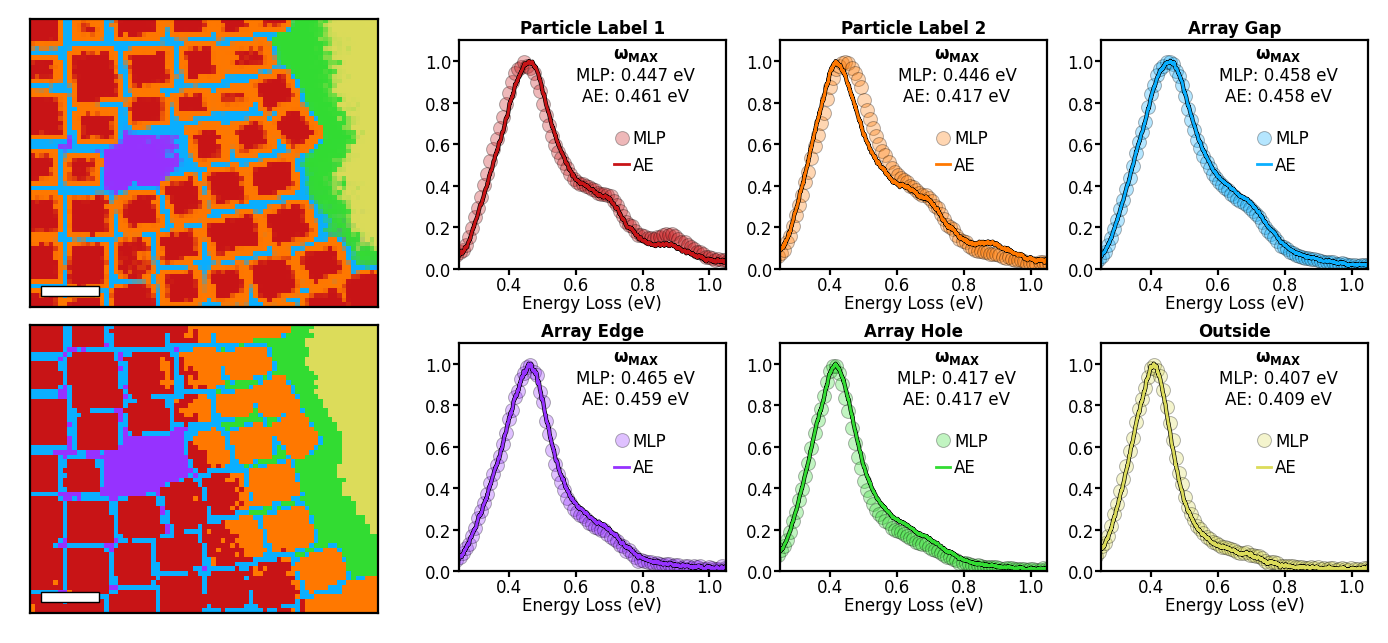

In [ ]:
#@title Unsupervised Labeling: Compare Supervised and Unsupervised Spectra of Labeled Regions

colors=np.asarray([Red,Orange,Blue,Purple,Green,Yellow])
gmm_i=[0,5,3,1,4,2] #Adjust to match GMM parameters to MLP parameters
gmm_labels=[labels_ae_3[2][i] for i in gmm_i]
fig=plt.figure(figsize=(6.7,3),dpi=200)
ax=fig.add_axes([0,0.51,0.26,0.49],xticks=[],yticks=[])
ax.imshow(MakeCompositeImage(nnlabels[2],colors))
ax.add_patch(Rectangle((2,d1-5),20/SI1_cal,2,fc='w',ec='k',lw=0.5))

ax=fig.add_axes([0,0,0.26,0.49],xticks=[],yticks=[])
ax.imshow(MakeCompositeImage(gmm_labels,colors))
ax.add_patch(Rectangle((2,d1-5),20/SI1_cal,2,fc='w',ec='k',lw=0.5))

aespecs = GetComponentSpectrum(NMFdat,labels_ae_3[2])
Labels=['Particle Label 1','Particle Label 2','Array Gap','Array Edge','Array Hole','Outside']
for i in range(6):
  ax=fig.add_subplot(2,3,i+1)
  ax.plot(E,NormArray(nnspecs[2][i]),lw=0,mew=0.35,mec='k',mfc=colors[i],marker='o',alpha=0.3,markersize=5,markevery=30,label='MLP')
  ax.plot(E,NormArray(aespecs[gmm_i[i]]),color='k',lw=1.5)
  ax.plot(E,NormArray(aespecs[gmm_i[i]]),color=colors[i],lw=1,label='AE')
  ax.tick_params(labelsize=6,length=2,pad=0.5)
  ax.set_xlabel('Energy Loss (eV)',fontsize=6,labelpad=0)
  ax.set_title(Labels[i],fontsize=6,fontweight='bold',va='top',y=1.02)
  ax.text(0.78,1.075,r'$\mathbf{\omega_{MAX}}$',fontsize=6,ha='center',va='top')
  ax.text(0.78,0.975,'MLP: '+str(round(E[np.argmax(nnspecs[2][i])],3))+' eV',fontsize=6,ha='center',va='top')
  ax.text(0.78,0.875,'AE: '+str(round(E[np.argmax(aespecs[gmm_i[i]])],3))+' eV',fontsize=6,ha='center',va='top')
  ax.legend(frameon=False,fontsize=6,handlelength=0.85,handletextpad=0.25,loc='lower center',bbox_to_anchor=(0.68,0.35))
  ax.set_xlim(0.25,1.05);ax.set_ylim(0,1.1)
  plt.subplots_adjust(left=0.32,right=0.999,top=0.96,bottom=0.075,hspace=0.325)